# Reason

## Research Motivation and Objectives

This research investigates online political discourse surrounding the 2025 Canadian federal election through systematic analysis of Reddit discussions. Our primary objectives are to:

The 2025 Canadian federal election represents a pivotal moment in Canadian politics, with major developments including Prime Minister Justin Trudeau's resignation and significant external pressures such as trade tensions with the United States.

Understanding Reddit sentiment matters because:
- Reddit users tend to be politically engaged and often serve as early indicators of broader public opinion
- Subreddit communities provide insights into how different partisan groups frame and react to political events
- Online discourse increasingly influences traditional media narratives and voter perceptions

## Definition of Political Wings

For this analysis, we classify political content into three categories based on partisan alignment:

- **Conservative**: Content aligned with right-leaning Canadian politics, typically supporting the Conservative Party of Canada (CPC), Pierre Poilievre's leadership, fiscal conservatism, and traditional values
- **Liberal**: Content aligned with center-left Canadian politics, typically supporting the Liberal Party of Canada, progressive policies, and social liberalism
- **Centrist**: Content that is politically neutral, balanced, or does not clearly align with either major partisan camp

This classification is applied to both subreddits (based on their community political lean) and individual submissions (using machine learning classification of post content).

## Data Scope

**Subreddits Analyzed:**
- Major Canadian political discussion forums representing diverse ideological perspectives
- Both explicitly political subreddits and general Canadian community forums where political discussions occur

**Time Period:**
- Data collected during the 2025 Canadian federal election campaign
- Analysis focuses on weekly and daily trends to capture evolving discourse patterns
- Special attention to major political events including:
  - Donald Trump's tariff announcement (impacting Canada-US relations)
  - Justin Trudeau's resignation as Prime Minister and Liberal Party leader


p.s. here you can see how Canadian exit polls have changed over time

![regression](image.png)


# Reddit Research Analysis Plan

## Overview
Share of news related to elections and potential hot topics → two charts

**Total Expected Outputs:** ~29 questions + visualizations

---

## EDA (Exploratory Data Analysis)

### General Activity Metrics
- **How many total posts were there each week?** *(1 visualization)*
  - Weekly time series plot of total post volume
  - Shows overall Reddit activity trends over time

### Election-Related Content
- **What % of submissions/comments were election-related?** *(3 visualizations)*
  - Weekly ratio of election-related submissions over time
  - Weekly ratio of election-related comments over time
  - Overall proportion comparison (pie charts for submissions and comments)
  - Results: ~35% of both submissions and comments are election-related

### Engagement Analysis
- **How many comments did election-related submissions have on average compared to all submissions?** *(2 visualizations)*
  - Weekly average comments comparison (line plot)
  - Monthly average comments comparison (grouped bar chart)
  - Compares election-related vs. all submissions

- **Average score over time for submissions** *(2 visualizations)*
  - Weekly median score over time (election-related vs. all)
  - Weekly mean score over time (election-related vs. all)

### Subreddit Popularity
- **Which were the most popular subreddits?** *(3 visualizations)*
  - Top 15 by submission count (horizontal bar chart)
  - Top 15 by comment count (horizontal bar chart)
  - Top 15 by total upvotes/score (horizontal bar chart)
  - Top subreddits: r/canada, r/CanadaPolitics, r/onguardforthee

- **How many posts did each subreddit contribute over time?** *(1 visualization)*
  - Weekly time series for top 10 subreddits showing submission trends

**Subtotal: 15 visualizations**

---

## Sentiment Analysis

### Political Wing Classification

- **Average submission score by political leaning over time** *(1 visualization)*
  - Weekly average score by political category (Liberal/Conservative/Centrist)
  - Text-based categorization using keywords

### Wing-Based Engagement
- **Which political wing's submissions received the most reactions?** *(1 visualization)*
  - Compare reaction metrics by political wing

- **Which political wing's submissions had more comments?** *(1 visualization)*
  - Mean number of comments per submission over time

- **Which political wing's submissions had higher sentiment scores over time?** *(1 visualization)*
  - Sentiment trends by political wing

### Subreddit Political Leaning
- **Do subreddits exist with clear political leanings where only left or only right views dominate?**
  - Identify politically homogeneous communities

**Subtotal: 3+ questions + visualizations**

---

## Entity Analysis (Political Figures)

*Note: Drop countries and cities*

### Entity Mentions in Election Content
- **Who appeared most frequently in election-related posts?** *(2 visualizations)*
  - Over time trend
  - Bar plot summary

### Political Context of Key Figures
- **Where did Trudeau, Trump, Mark Carney, and Pierre Poilievre appear most frequently?** *(1 visualization)*
  - Presence in left/right/centrist discussions

### Sentiment Toward Political Figures
- **What was the sentiment among liberals, conservatives, and centrists toward:** *(8 visualizations)*
  - Trudeau (over time + bar plot)
  - Trump (over time + bar plot)
  - Mark Carney (over time + bar plot)
  - Pierre Poilievre (over time + bar plot)

**Subtotal: 11 questions + visualizations**

---

## Causal Inference

### Event Impact Analysis
*Methodology: t-test on sentiment for dates before and after each event*

#### Key Events to Analyze:
1. **US Election**
   - Did it affect sentiment and activity changes among liberals/conservatives/centrists?

2. **Tariffs**
   - Did they affect sentiment and activity changes among liberals/conservatives/centrists?

3. **Debates**
   - Did they affect sentiment and activity changes among liberals/conservatives/centrists?

4. **Trudeau's Resignation**
   - Did it affect sentiment and activity changes among liberals/conservatives/centrists?

5. **New Prime Minister's Arrival**
   - Did it affect sentiment and activity changes among liberals/conservatives/centrists?

### Comparative Analysis
- **Which of these hypotheses had the greatest impact on change?** *(1 visualization)*
  - Compare effect sizes across all events

**Subtotal: 6 questions + analyses**

---

## Summary Statistics
- **Total visualizations:** ~33
- **Main sections:** 4 (EDA, Sentiment, Entities, Causal Inference)
- **Political categories:** Liberal, Conservative, Centrist
- **Key figures tracked:** Trudeau, Trump, Carney, Poilievre

In [9]:
import os
import re
import ast
from collections import Counter

import numpy as np
import pandas as pd
import torch
from scipy import stats as scipy_stats

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import spacy
from langdetect import LangDetectException, detect
from textblob import TextBlob
from tqdm import tqdm
from transformers import pipeline

import plotly.io as pio
pio.renderers.default = "png"

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Data load and preprocessing steps

First we need to load data and find out which columns will we use for analysis. Reddit submissions contains 120 columns and comments 74. Obviously we won't use them all, so we need to choose the most important.

In [10]:
folder = "data"

rs_files = [f for f in os.listdir(folder) if f.startswith("RS") and f.endswith(".csv")]
rc_files = [f for f in os.listdir(folder) if f.startswith("RC") and f.endswith(".csv")]

def get_common_columns(files):
    common_cols = None
    for filename in files:
        path = os.path.join(folder, filename)
        df = pd.read_csv(path, nrows=0)
        cols = set(df.columns)
        if common_cols is None:
            common_cols = cols
        else:
            common_cols |= cols
    return common_cols or set()

rs_common = get_common_columns(rs_files)
rc_common = get_common_columns(rc_files)

print("Common columns in RS files:", rs_common)
print("Common columns in RC files:", rc_common)

print("Total number of columns in RS files:", len(rs_common))
print("Total number of columns in RC files:", len(rc_common))

Common columns in RS files: {'subreddit_id', 'total_awards_received', 'link_flair_type', 'thumbnail_width', 'media', 'author_premium', 'thumbnail_height', 'is_crosspostable', 'num_comments', 'selftext', 'score', 'mod_reason_title', 'contest_mode', 'hidden', 'subreddit_type', 'link_flair_richtext', 'is_original_content', '_meta', 'author_flair_background_color', 'is_created_from_ads_ui', 'num_reports', 'retrieved_on', 'banned_by', 'downs', 'stickied', 'clicked', 'name', 'media_embed', 'send_replies', 'url_overridden_by_dest', 'removed_by_category', 'awarders', 'poll_data', 'parent_whitelist_status', 'category', 'is_gallery', 'crosspost_parent_list', 'treatment_tags', 'discussion_type', 'post_hint', 'author_patreon_flair', 'link_flair_background_color', 'suggested_sort', 'link_flair_text_color', 'author_cakeday', 'is_robot_indexable', 'author_flair_text_color', 'removed_by', 'archived', 'upvote_ratio', 'is_self', 'created_utc', 'approved_at_utc', 'previous_selftext', 'link_flair_text', '

In [11]:
rs_columns = ['id', 'author', 'created_utc', 'subreddit', 'title', 'selftext',
 'link_flair_text', 'domain', 'score', 'ups', 'downs', 'num_comments',
 'upvote_ratio', 'total_awards_received', 'retrieved_on', 'is_original_content']

rc_columns = ['id', 'author', 'created_utc', 'subreddit', 'body', 'score',
 'ups', 'downs', 'parent_id', 'link_id', 'is_submitter', 
 'controversiality', 'total_awards_received', 'retrieved_on']

We decided to leave those columns as they give us almost all information we need to conduct our analysis and get some meaningful results. We may alter these during our experiments and analysis.

In [12]:
def read_subset(file, columns, source_type):
    path = os.path.join(folder, file)
    try:
        df = pd.read_csv(path, usecols=lambda c: c in columns)
        df = df.reindex(columns=columns)
        df["source_type"] = source_type
        return df
    except Exception as e:
        return pd.DataFrame(columns=columns + ["source_type"])

if not os.path.exists("preprocessed/reddit_submissions_filtered.csv") or not os.path.exists("preprocessed/reddit_comments_filtered.csv"):
    rs_dfs = [read_subset(f, rs_columns, "submission") for f in rs_files]
    rc_dfs = [read_subset(f, rc_columns, "comment") for f in rc_files]

In [13]:
if not os.path.exists("preprocessed/reddit_submissions_filtered.csv"):
    submissions_df = pd.concat(rs_dfs, ignore_index=True)
    submissions_df.to_csv("preprocessed/reddit_submissions_filtered.csv", index=False)
else:
    submissions_df = pd.read_csv("preprocessed/reddit_submissions_filtered.csv")

if not os.path.exists("preprocessed/reddit_comments_filtered.csv"):
    comments_df = pd.concat(rc_dfs, ignore_index=True)
    comments_df.to_csv("preprocessed/reddit_comments_filtered.csv", index=False)
else:
    comments_df = pd.read_csv("preprocessed/reddit_comments_filtered.csv")
    comments_df = comments_df[comments_df['created_utc'] > 1704116554]

In [14]:
print(f"Submissions DataFrame: {len(submissions_df):,} rows, {len(submissions_df.columns)} columns")
print(f"Comments DataFrame: {len(comments_df):,} rows, {len(comments_df.columns)} columns")

Submissions DataFrame: 355,382 rows, 17 columns
Comments DataFrame: 11,613,821 rows, 15 columns


In [15]:
if not os.path.exists("preprocessed/reddit_combined.csv"):
    comments_df["link_id_clean"] = comments_df["link_id"].str.replace("t3_", "", regex=False)
    
    joined_df = comments_df.merge(
        submissions_df,
        left_on="link_id_clean",
        right_on="id",
        suffixes=("_comment", "_submission")
    )
    
    joined_df.to_csv("preprocessed/reddit_combined.csv", index=False)

In [16]:
joined_df = pd.read_csv("preprocessed/reddit_combined.csv")

In [17]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
if not os.path.exists("preprocessed/filtered_submissions.csv") or not os.path.exists("preprocessed/filtered_comments.csv"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=device,
        batch_size=512,
        max_length=512,
        truncation=True,
        dtype=torch.float16
    )
    
    candidate_labels = ["Canadian elections and Canadian politics", "other topics"]
    
    submission_texts = (submissions_df['title'].fillna('') + ' ' + submissions_df['selftext'].fillna('')).tolist()
    
    submission_results = []
    batch_size = 512
    
    for i in tqdm(range(0, len(submission_texts), batch_size), desc="Processing submissions"):
        batch = submission_texts[i:i+batch_size]
        batch_results = classifier(batch, candidate_labels)
        submission_results.extend(batch_results)
    
    submissions_df['is_canadian_politics'] = [1 if submission_results[i]['labels'][0] == "Canadian elections and Canadian politics" else 0 for i in range(len(submission_results))]
    submissions_df['confidence_score'] = [submission_results[i]['scores'][0] for i in range(len(submission_results))]
    
    filtered_submissions = submissions_df[submissions_df['is_canadian_politics'] == 1]

    comments_df["link_id_clean"] = comments_df["link_id"].str.replace("t3_", "", regex=False)
    
    filtered_comments = comments_df[comments_df["link_id_clean"].isin(filtered_submissions["id"])]
    
    filtered_submissions.to_csv("preprocessed/filtered_submissions.csv", index=False)
    filtered_comments.to_csv("preprocessed/filtered_comments.csv", index=False)
    
    print(f"Filtered {len(filtered_submissions)} submissions and {len(filtered_comments)} comments")

Filtered 52447 submissions and 3151069 comments


In [23]:
filtered_submissions

,id,author,created_utc,subreddit,title,selftext,link_flair_text,domain,score,ups,downs,num_comments,upvote_ratio,total_awards_received,retrieved_on,is_original_content,source_type,is_canadian_politics,confidence_score
0,1h3qaar,james2432,1.733012e+09,ottawa,R1 bus in effect,NaN,Satire,i.redd.it,75,75,0,7,0.89,0,1733011859,False,submission,1,0.553505
1,1h3qmr3,chironelon12,1.733013e+09,canada,Canadian parliamentary petition on UAP/UFOs di...,[removed],Politics,ourcommons.ca,1,1,0,0,1.00,0,1733012866,False,submission,1,0.533640
2,1h3qsud,chironelon12,1.733013e+09,canada,Canadian parliamentary petition for UFO/UAP di...,NaN,Politics,ourcommons.ca,1,1,0,0,1.00,0,1733013366,False,submission,1,0.566978
3,1h3qz2q,Ok_Education1123,1.733014e+09,AskACanadian,Have you ever met someone named after a state?,NaN,NaN,self.AskACanadian,1,1,0,0,1.00,0,1733013879,False,submission,1,0.509764
4,1h3r3dl,Mountain_Community38,1.733014e+09,canada,you’re a generational idiot if your against th...,[removed],Politics,self.canada,1,1,0,0,1.00,0,1733014238,False,submission,1,0.539954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52442,1f5z35q,hopoke,1.725143e+09,CanadaPolitics,Is Justin Trudeau’s political future at stake ...,NaN,NaN,winnipeg.citynews.ca,21,21,0,41,0.66,0,1725142641,False,submission,1,0.944485
52443,1f5zadb,PolloConTeriyaki,1.725143e+09,britishcolumbia,BC ELECTION: Register to vote by mail! The eas...,NaN,Politics,elections.bc.ca,136,136,0,22,0.91,0,1725143220,False,submission,1,0.586996
52444,1f5zj2m,AmazingRandini,1.725144e+09,GreenPartyOfCanada,Why is the green party against nuclear power?,Despite the fact that it has zero carbon emiss...,Discussion,self.GreenPartyOfCanada,22,22,0,30,0.95,0,1725143944,False,submission,1,0.520984
52445,1f605ne,Weekly_Statement_610,1.725146e+09,canada,Krystal Forscutt,[removed],Opinion Piece,reddit.com,1,1,0,0,1.00,0,1725145751,False,submission,1,0.540924


In [27]:
if not os.path.exists("preprocessed/election_submissions.csv") or not os.path.exists("preprocessed/election_comments.csv"):
    filtered_submissions = pd.read_csv("preprocessed/filtered_submissions.csv")
    filtered_comments = pd.read_csv("preprocessed/filtered_comments.csv")

    filtered_submissions['full_text'] = filtered_submissions['title'].fillna('') + ' ' + filtered_submissions['selftext'].fillna('')
    
    def get_sentiment_tb(text):
        if pd.isna(text):
            return 0
        return TextBlob(text).sentiment.polarity

    filtered_comments['sentiment_score'] = filtered_comments['body'].apply(get_sentiment_tb)
    filtered_submissions['sentiment_score'] = filtered_submissions['full_text'].apply(get_sentiment_tb)
    
    texts = [str(t) if pd.notna(t) and t != '' else ' ' for t in filtered_submissions['full_text']]
    
    people_list = []
    places_list = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=1024, n_process=8), total=len(texts)):
        people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        places = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
        people_list.append(", ".join(people))
        places_list.append(", ".join(places))

    filtered_submissions['people'] = people_list
    filtered_submissions['places'] = places_list
    
    texts = [str(t) if pd.notna(t) and t != '' else ' ' for t in filtered_comments['body']]
    
    people_list = []
    places_list = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=1024, n_process=8), total=len(texts)):
        people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        places = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
        people_list.append(", ".join(people))
        places_list.append(", ".join(places))

    filtered_comments['people'] = people_list
    filtered_comments['places'] = places_list
    
    filtered_submissions.to_csv("preprocessed/election_submissions.csv", index=False)
    filtered_comments.to_csv("preprocessed/election_comments.csv", index=False)

100%|██████████| 3151069/3151069 [48:20<00:00, 1086.54it/s] 


In [128]:
election_submissions = pd.read_csv("preprocessed/election_submissions.csv")
election_comments = pd.read_csv("preprocessed/election_comments.csv")
election_comments = election_comments[election_comments['created_utc'] > 1704116554]

In [ ]:
if not os.path.exists("preprocessed/predicts.csv"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=device,
        batch_size=512,
        max_length=512,
        truncation=True,
        dtype=torch.float16
    )

    candidate_labels = ["liberal", "conservative", "centrist"]

    texts = df['full_text'].tolist()

    results = []
    batch_size = 512

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch = texts[i:i+batch_size]
        batch_results = classifier(batch, candidate_labels)
        results.extend(batch_results)


    df_results = pd.DataFrame([{
        'text': texts[i],
        'label': results[i]['labels'],
        'score': results[i]['scores']
    } for i in range(len(results))])

    df_results.to_csv('preprocessed/predicts.csv', index=False)

In [129]:
predicts = pd.read_csv('preprocessed/predicts.csv')

We used two models for text analysis in this research. The first model is spaCy's en_core_web_sm, a lightweight English language processing model. We applied it to extract named entities from Reddit posts and comments, specifically identifying people (PERSON entities) and geographic locations (GPE entities). This helped us track mentions of political figures like Trudeau, Trump, Carney, and Poilievre throughout the dataset. The model processed texts in batches of 500 using 4 parallel processes for efficiency.

The second model is Facebook's BART-large-MNLI, a zero-shot classification model. We used it to categorize Reddit content into three political leanings: liberal, conservative, and centrist. This classification allowed us to analyze how different political groups discussed election-related topics and reacted to various political events. The model was configured to run on GPU when available, processing texts in batches of 128 with a maximum length of 512 tokens, using float16 precision for faster inference.

# EDA/Data overview

## General Activity Metrics - Daily Post Volume

In [130]:
for df in [election_submissions, election_comments, submissions_df, comments_df]:
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

## How many total posts were there each week?

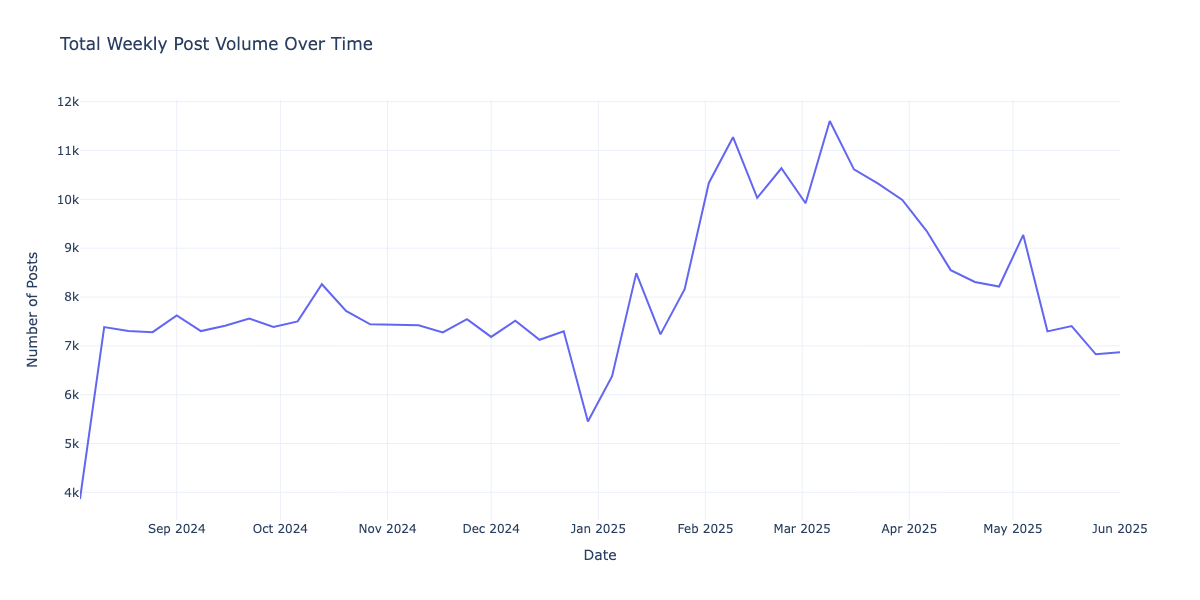

In [131]:
daily_posts = submissions_df.groupby(pd.Grouper(key='created_utc', freq='W')).size()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=daily_posts.index,
    y=daily_posts.values,
    mode='lines',
    name='Weekly Posts',
    line=dict(color='#6366F1', width=2)
))
fig.update_layout(
    title='Total Weekly Post Volume Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Posts',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
)
fig.show()

Here we see that the absolute number of weekly publications has almost doubled since the events of January 2025

## What percentage of submissions/comments were election-related?

## Election-Related Content - Ratio Over Time

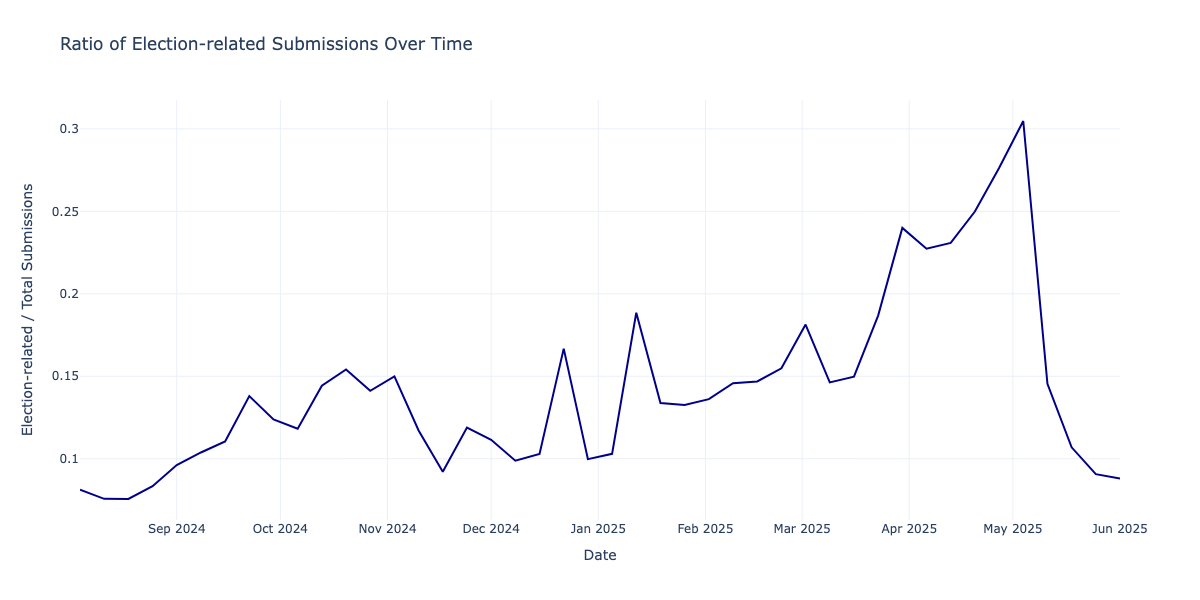

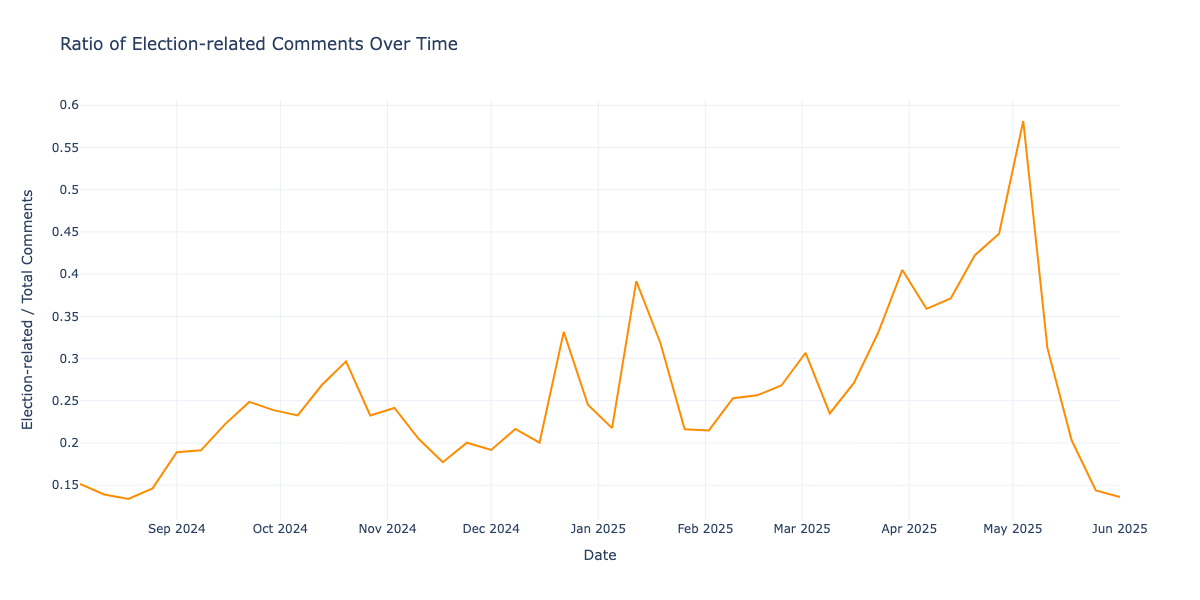

In [132]:
submissions_daily = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='W'))
    .size()
    .rename('total_submissions')
)

election_submissions_daily = (
    election_submissions.groupby(pd.Grouper(key='created_utc', freq='W'))
    .size()
    .rename('election_submissions')
)

comments_daily = (
    comments_df.groupby(pd.Grouper(key='created_utc', freq='W'))
    .size()
    .rename('total_comments')
)

election_comments_daily = (
    election_comments.groupby(pd.Grouper(key='created_utc', freq='W'))
    .size()
    .rename('election_comments')
)

submissions_trend = pd.concat([submissions_daily, election_submissions_daily], axis=1).fillna(0)
comments_trend = pd.concat([comments_daily, election_comments_daily], axis=1).fillna(0)

submissions_trend['ratio'] = submissions_trend['election_submissions'] / submissions_trend['total_submissions']
comments_trend['ratio'] = comments_trend['election_comments'] / comments_trend['total_comments']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=submissions_trend.index,
    y=submissions_trend['ratio'],
    mode='lines',
    name='Weekly ratio',
    line=dict(color='darkblue'),
    opacity=1
))

fig.update_layout(
    title='Ratio of Election-related Submissions Over Time',
    xaxis_title='Date',
    yaxis_title='Election-related / Total Submissions',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1200,
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=comments_trend.index,
    y=comments_trend['ratio'],
    mode='lines',
    name='Weekly ratio',
    line=dict(color='darkorange'),
    opacity=1
))

fig.update_layout(
    title='Ratio of Election-related Comments Over Time',
    xaxis_title='Date',
    yaxis_title='Election-related / Total Comments',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1200,
)
fig.show()

From this plot we can clearly see that topicality of elections increases as  time to elections reduces. We also see different spikes(e.g. Trump inauguration), which are expected as they increased political and elections debate.
We can also notice that comments have higher ratio, which could be explained by the fact that politics is more controverisial topic than cats dogs or canadian forests.

## How many comments did election-related submissions have on average compared to all submissions?

### Overall Proportion Comparison

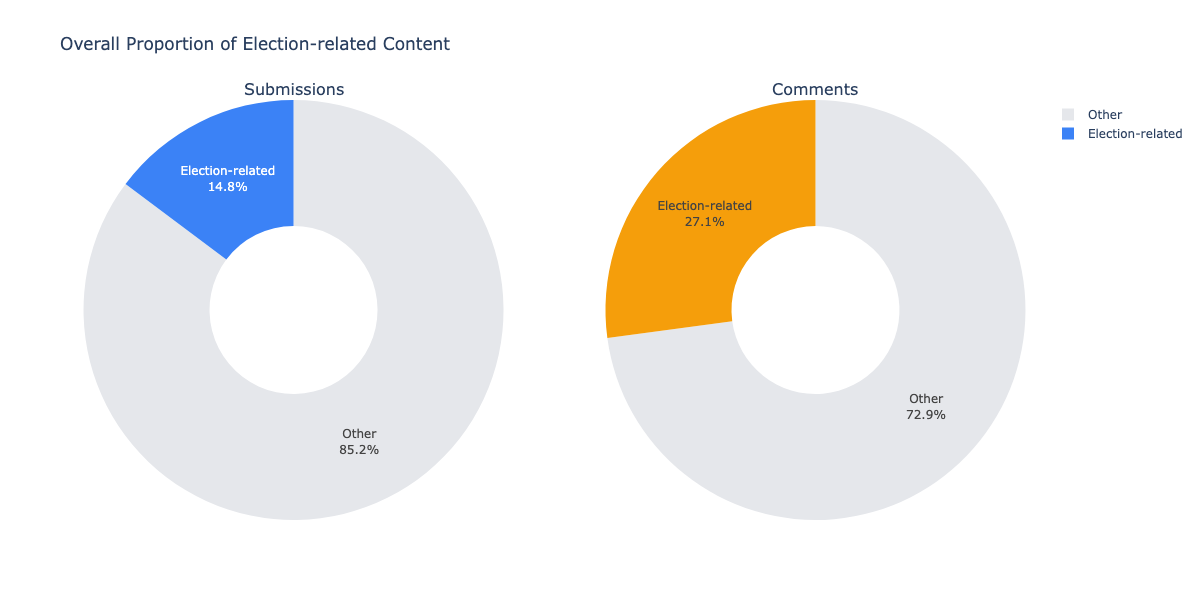

Total Submissions: 355,382
Election-related Submissions: 52,447 (14.76%)

Total Comments: 11,613,821
Election-related Comments: 3,151,069 (27.13%)


In [133]:
total_submissions = len(submissions_df)
election_submissions_count = len(election_submissions)
total_comments = len(comments_df)
election_comments_count = len(election_comments)

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]],
    subplot_titles=('Submissions', 'Comments')
)

fig.add_trace(go.Pie(
    labels=['Election-related', 'Other'],
    values=[election_submissions_count, total_submissions - election_submissions_count],
    marker=dict(colors=['#3B82F6', '#E5E7EB']),
    hole=0.4,
    textinfo='label+percent',
    textposition='inside'
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=['Election-related', 'Other'],
    values=[election_comments_count, total_comments - election_comments_count],
    marker=dict(colors=['#F59E0B', '#E5E7EB']),
    hole=0.4,
    textinfo='label+percent',
    textposition='inside'
), row=1, col=2)

fig.update_layout(
    title='Overall Proportion of Election-related Content',
    showlegend=True,
    height=600,
    width=1200,
    template='plotly_white'
)
fig.show()

print(f"Total Submissions: {total_submissions:,}")
print(f"Election-related Submissions: {election_submissions_count:,} ({election_submissions_count/total_submissions*100:.2f}%)")
print(f"\nTotal Comments: {total_comments:,}")
print(f"Election-related Comments: {election_comments_count:,} ({election_comments_count/total_comments*100:.2f}%)")

## Engagement Analysis - Average Comments by Week

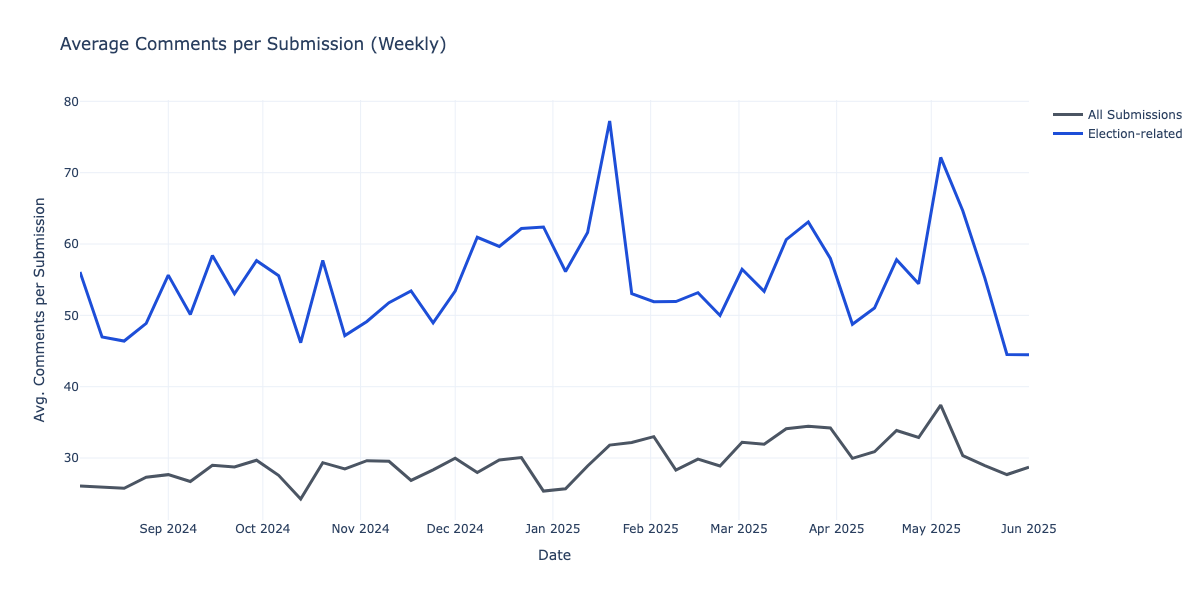

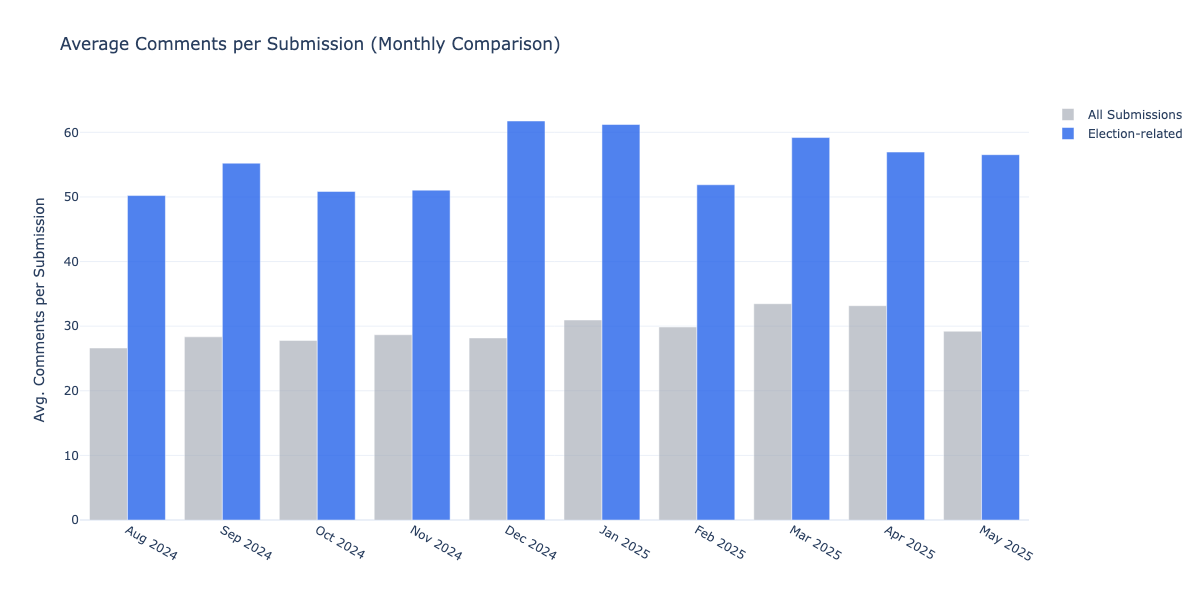

In [134]:
submissions_df['created_utc'] = pd.to_datetime(submissions_df['created_utc'], unit='s', errors='coerce')

submissions_df['is_election_related'] = submissions_df['id'].isin(election_submissions['id'])

weekly_total_avg = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='W'))['num_comments']
    .mean()
)
weekly_election_avg = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='W'))['num_comments']
    .mean()
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_total_avg.index,
    y=weekly_total_avg.values,
    mode='lines',
    name='All Submissions',
    line=dict(color='#4B5563', width=3)
))
fig.add_trace(go.Scatter(
    x=weekly_election_avg.index,
    y=weekly_election_avg.values,
    mode='lines',
    name='Election-related',
    line=dict(color='#1D4ED8', width=3)
))

fig.update_layout(
    title='Average Comments per Submission (Weekly)',
    xaxis_title='Date',
    yaxis_title='Avg. Comments per Submission',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
)
fig.show()


monthly_total_avg = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='ME'))['num_comments']
    .mean()
    .rename('All Submissions')
)
monthly_election_avg = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='ME'))['num_comments']
    .mean()
    .rename('Election-related')
)

monthly_avg_comments = pd.concat([monthly_total_avg, monthly_election_avg], axis=1).fillna(0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthly_avg_comments.index.strftime('%b %Y'),
    y=monthly_avg_comments['All Submissions'],
    name='All Submissions',
    marker_color='#9CA3AF',
    opacity=0.6
))
fig.add_trace(go.Bar(
    x=monthly_avg_comments.index.strftime('%b %Y'),
    y=monthly_avg_comments['Election-related'],
    name='Election-related',
    marker_color='#2563EB',
    opacity=0.8
))
fig.update_layout(
    title='Average Comments per Submission (Monthly Comparison)',
    xaxis_title='',
    yaxis_title='Avg. Comments per Submission',
    barmode='group',
    template='plotly_white',
    height=600,
    width=1200,
    xaxis=dict(tickangle=30)
)
fig.show()

These illustrations show trends that election-related materials are more controversial among people compared to general materials.

## What was the average score over time for submissions?

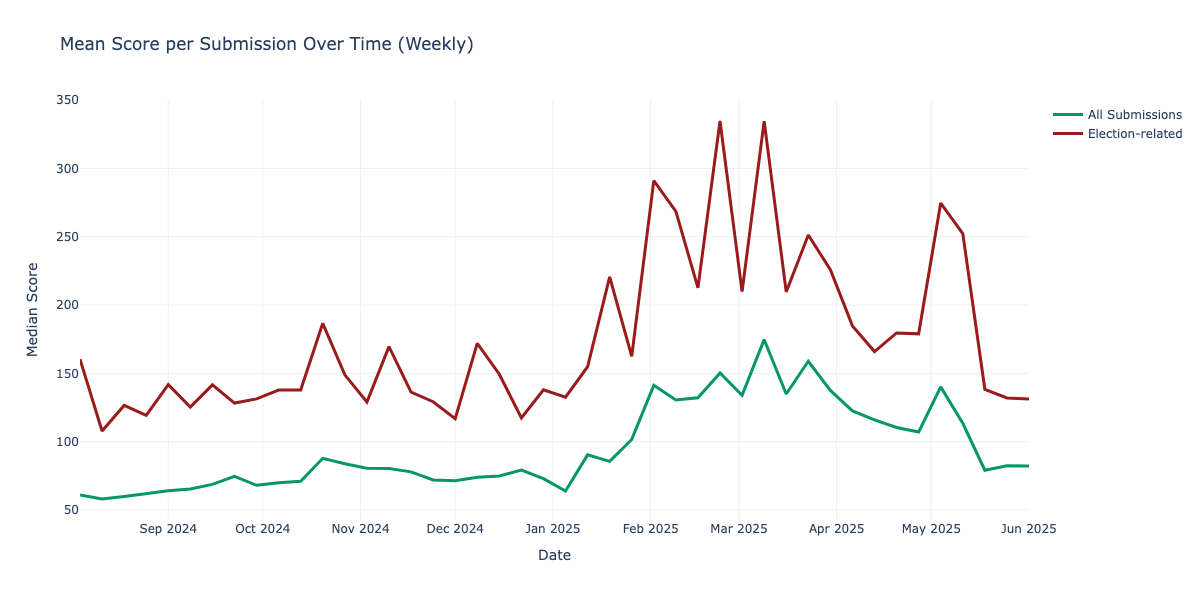

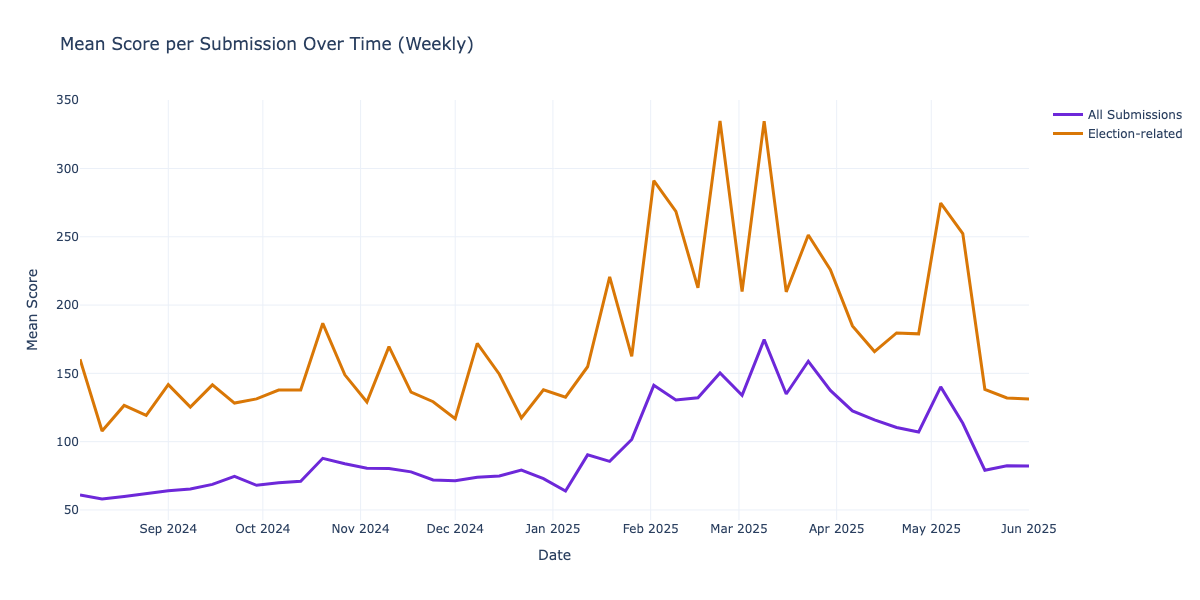

In [135]:
weekly_total_score = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='W'))['score']
    .mean()
)
weekly_election_score = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='W'))['score']
    .mean()
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_total_score.index,
    y=weekly_total_score.values,
    mode='lines',
    name='All Submissions',
    line=dict(color='#059669', width=3)
))
fig.add_trace(go.Scatter(
    x=weekly_election_score.index,
    y=weekly_election_score.values,
    mode='lines',
    name='Election-related',
    line=dict(color='#991B1B', width=3)
))

fig.update_layout(
    title='Mean Score per Submission Over Time (Weekly)',
    xaxis_title='Date',
    yaxis_title='Median Score',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
)
fig.show()

weekly_total_mean = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='W'))['score']
    .mean()
)
weekly_election_mean = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='W'))['score']
    .mean()
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_total_mean.index,
    y=weekly_total_mean.values,
    mode='lines',
    name='All Submissions',
    line=dict(color='#6D28D9', width=3)
))
fig.add_trace(go.Scatter(
    x=weekly_election_mean.index,
    y=weekly_election_mean.values,
    mode='lines',
    name='Election-related',
    line=dict(color='#D97706', width=3)
))

fig.update_layout(
    title='Mean Score per Submission Over Time (Weekly)',
    xaxis_title='Date',
    yaxis_title='Mean Score',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
)
fig.show()

## Subreddit Popularity

### Top Subreddits by Submission Count

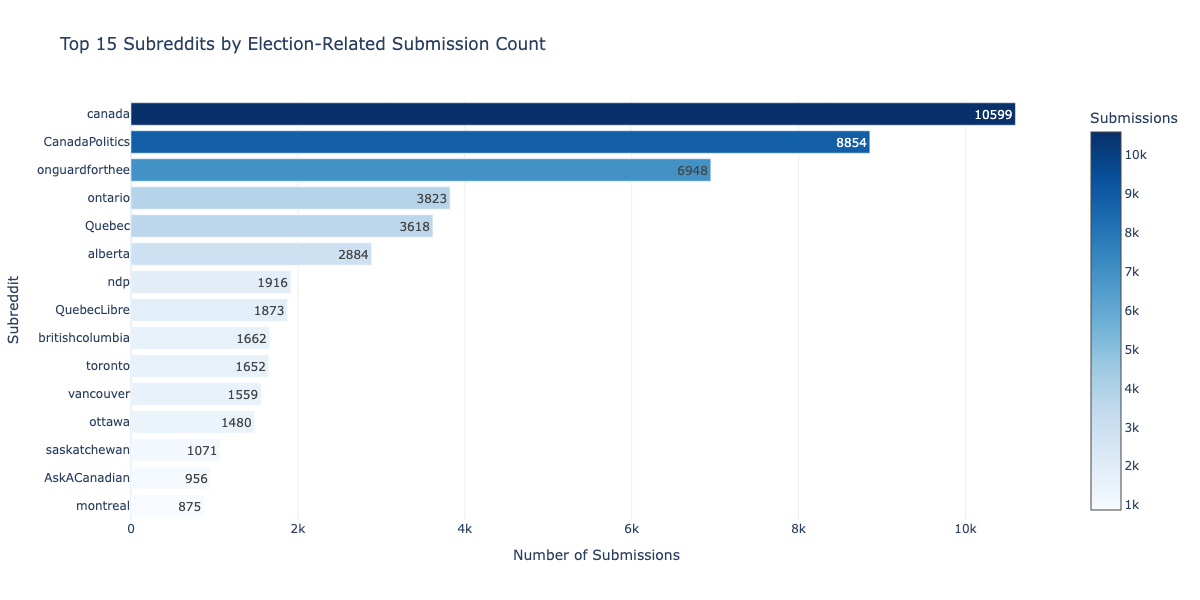

Total unique subreddits: 22

Top 5 subreddits:
1. r/canada: 10,599 submissions
2. r/CanadaPolitics: 8,854 submissions
3. r/onguardforthee: 6,948 submissions
4. r/ontario: 3,823 submissions
5. r/Quebec: 3,618 submissions


In [136]:
top_subreddits_by_submissions = (
    election_submissions['subreddit']
    .value_counts()
    .head(15)
)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=top_subreddits_by_submissions.values,
    y=top_subreddits_by_submissions.index,
    orientation='h',
    marker=dict(
        color=top_subreddits_by_submissions.values,
        colorscale='Blues',
        showscale=True,
        colorbar=dict(title="Submissions")
    ),
    text=top_subreddits_by_submissions.values,
    textposition='auto',
))

fig.update_layout(
    title='Top 15 Subreddits by Election-Related Submission Count',
    xaxis_title='Number of Submissions',
    yaxis_title='Subreddit',
    template='plotly_white',
    height=600,
    width=1200,
    yaxis=dict(autorange='reversed')
)
fig.show()

print(f"Total unique subreddits: {election_submissions['subreddit'].nunique()}")
print(f"\nTop 5 subreddits:")
for idx, (subreddit, count) in enumerate(top_subreddits_by_submissions.head(5).items(), 1):
    print(f"{idx}. r/{subreddit}: {count:,} submissions")

This story answers the question of the contribution rate of each subreddit to the data by the number of submissions

### Top Subreddits by Comment Count

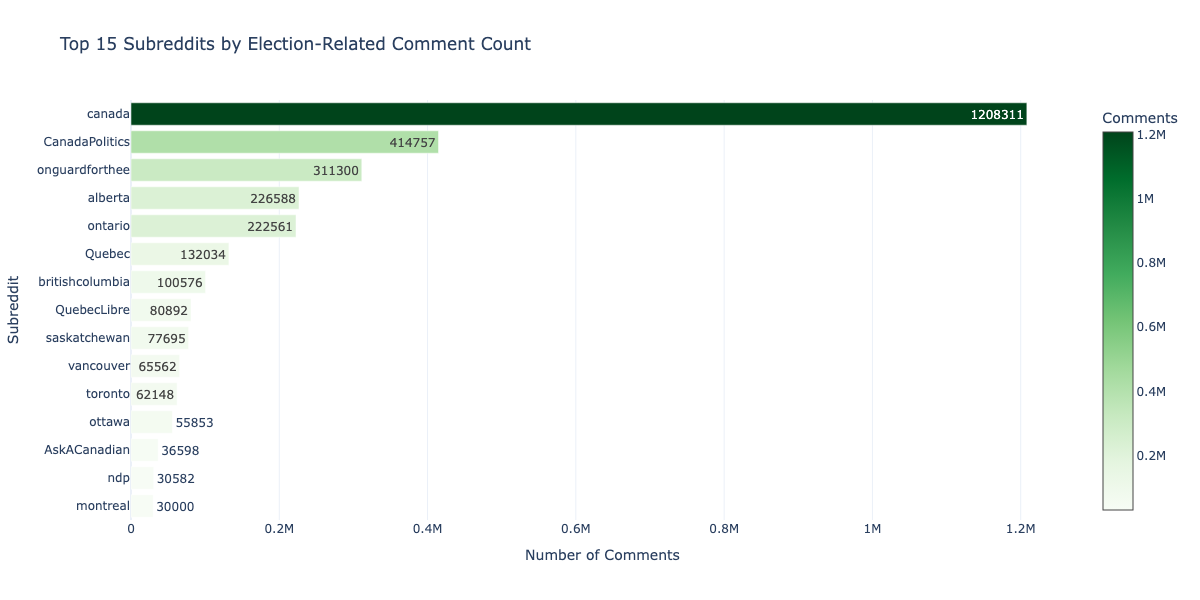

Total unique subreddits: 22

Top 5 subreddits by comments:
1. r/canada: 1,208,311 comments
2. r/CanadaPolitics: 414,757 comments
3. r/onguardforthee: 311,300 comments
4. r/alberta: 226,588 comments
5. r/ontario: 222,561 comments


In [137]:
top_subreddits_by_comments = (
    election_comments['subreddit']
    .value_counts()
    .head(15)
)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=top_subreddits_by_comments.values,
    y=top_subreddits_by_comments.index,
    orientation='h',
    marker=dict(
        color=top_subreddits_by_comments.values,
        colorscale='Greens',
        showscale=True,
        colorbar=dict(title="Comments")
    ),
    text=top_subreddits_by_comments.values,
    textposition='auto',
))

fig.update_layout(
    title='Top 15 Subreddits by Election-Related Comment Count',
    xaxis_title='Number of Comments',
    yaxis_title='Subreddit',
    template='plotly_white',
    height=600,
    width=1200,
    yaxis=dict(autorange='reversed')
)
fig.show()

print(f"Total unique subreddits: {election_comments['subreddit'].nunique()}")
print(f"\nTop 5 subreddits by comments:")
for idx, (subreddit, count) in enumerate(top_subreddits_by_comments.head(5).items(), 1):
    print(f"{idx}. r/{subreddit}: {count:,} comments")

Here we sort subreddits by total amount of comments

### Top Subreddits by Total Upvotes

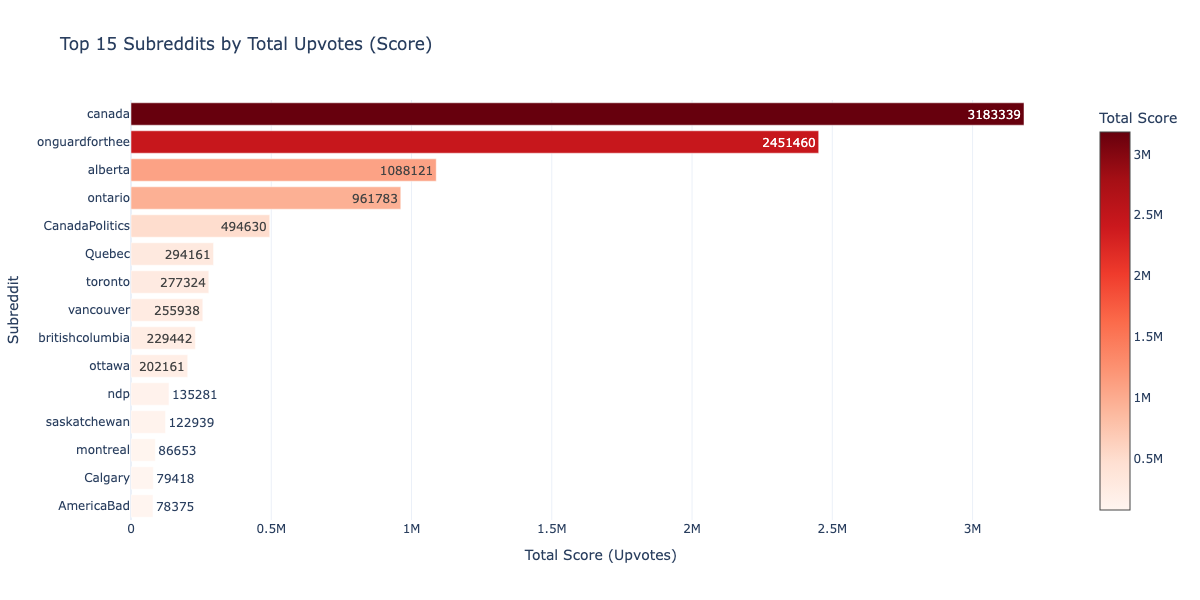


Top 5 subreddits by total upvotes:
1. r/canada: 3,183,339 total score
2. r/onguardforthee: 2,451,460 total score
3. r/alberta: 1,088,121 total score
4. r/ontario: 961,783 total score
5. r/CanadaPolitics: 494,630 total score

Average score per submission for top subreddits:
1. r/alberta: 377.3 avg score per submission
2. r/onguardforthee: 352.8 avg score per submission
3. r/canada: 300.3 avg score per submission
4. r/ontario: 251.6 avg score per submission
5. r/toronto: 167.9 avg score per submission
6. r/vancouver: 164.2 avg score per submission
7. r/britishcolumbia: 138.1 avg score per submission
8. r/ottawa: 136.6 avg score per submission
9. r/Quebec: 81.3 avg score per submission
10. r/CanadaPolitics: 55.9 avg score per submission


In [138]:
top_subreddits_by_upvotes = (
    election_submissions.groupby('subreddit')['score']
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=top_subreddits_by_upvotes.values,
    y=top_subreddits_by_upvotes.index,
    orientation='h',
    marker=dict(
        color=top_subreddits_by_upvotes.values,
        colorscale='Reds',
        showscale=True,
        colorbar=dict(title="Total Score")
    ),
    text=top_subreddits_by_upvotes.values,
    textposition='auto',
))

fig.update_layout(
    title='Top 15 Subreddits by Total Upvotes (Score)',
    xaxis_title='Total Score (Upvotes)',
    yaxis_title='Subreddit',
    template='plotly_white',
    height=600,
    width=1200,
    yaxis=dict(autorange='reversed')
)
fig.show()

print(f"\nTop 5 subreddits by total upvotes:")
for idx, (subreddit, score) in enumerate(top_subreddits_by_upvotes.head(5).items(), 1):
    print(f"{idx}. r/{subreddit}: {score:,} total score")

print(f"\nAverage score per submission for top subreddits:")
avg_scores = election_submissions.groupby('subreddit')['score'].mean().loc[top_subreddits_by_upvotes.head(10).index].sort_values(ascending=False)
for idx, (subreddit, avg_score) in enumerate(avg_scores.items(), 1):
    print(f"{idx}. r/{subreddit}: {avg_score:.1f} avg score per submission")

Here by scores

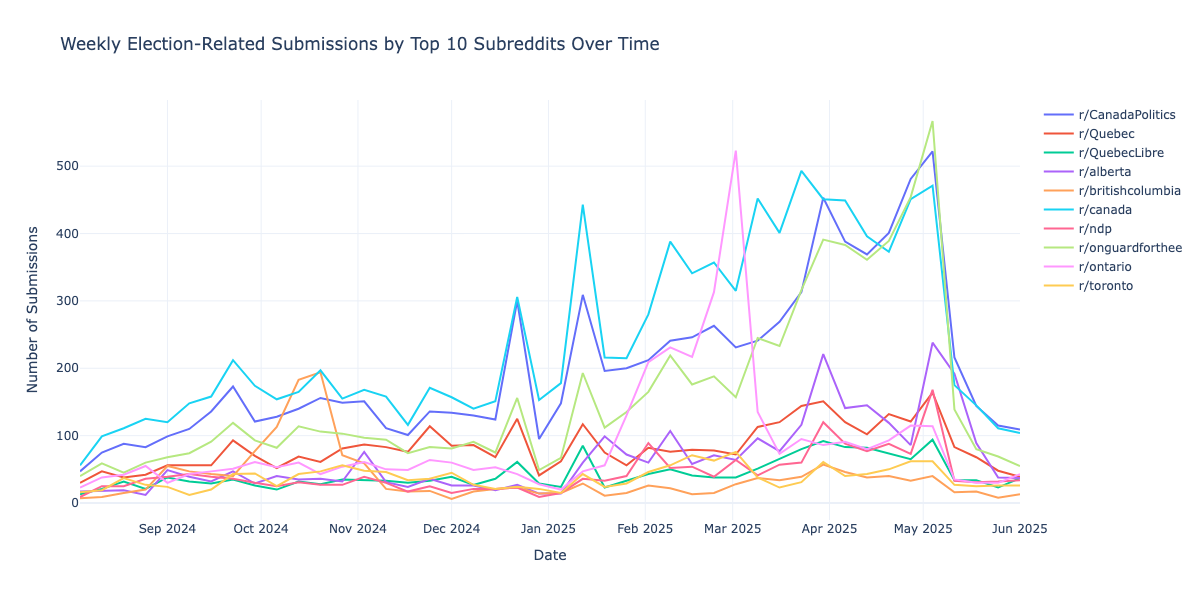

In [139]:
top_subreddits = election_submissions['subreddit'].value_counts().head(10).index

subreddit_time_series = (
    election_submissions[election_submissions['subreddit'].isin(top_subreddits)]
    .groupby([pd.Grouper(key='created_utc', freq='W'), 'subreddit'])
    .size()
    .unstack(fill_value=0)
)

fig = go.Figure()

colors = px.colors.qualitative.Set3

for idx, subreddit in enumerate(subreddit_time_series.columns):
    fig.add_trace(go.Scatter(
        x=subreddit_time_series.index,
        y=subreddit_time_series[subreddit],
        mode='lines',
        name=f'r/{subreddit}',
        line=dict(width=2),
    ))

fig.update_layout(
    title='Weekly Election-Related Submissions by Top 10 Subreddits Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Submissions',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)
fig.show()

Grouping data by subreddits can also answer questions about which ones were more popular during which periods.

## Section 2: Average Submission Score Over Time by Political Leaning

On this step we start to use ml predicted political wings to split users moods into three groups: liberal, conservative and centrists (submissions that do not have a clearly expressed political vector)

We have also started adding key events here that we believe may influence public sentiment

## What was the average submission score by political leaning over time?

In [140]:
events = [
    ("2024-11-05", "US Election Day"),
    ("2024-11-25", "Trump tariff tweet"),
    ("2024-12-01", "Canadian debate controversy"),
    ("2025-01-06", "Trudeau resignation"),
    ("2025-03-01", "New PM sworn in"),
    ("2025-04-28", "Federal Elections")
]

def add_event_markers(fig, events):
    for event_date, event_name in events:
        fig.add_vline(
            x=event_date,
            line_dash="dash",
            line_color="rgba(128, 128, 128, 0.5)",
            line_width=1.5
        )
        fig.add_annotation(
            x=event_date,
            y=-0.2,
            yref="paper",
            text=event_name,
            showarrow=False,
            textangle=10,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=9, color="gray")
        )


In [141]:
predicts['political_category'] = predicts['label'].apply(lambda x: ast.literal_eval(x)[0])

predicts = predicts.rename(columns={'text': 'full_text'})

In [142]:
election_submissions

,id,author,created_utc,subreddit,title,selftext,link_flair_text,domain,score,ups,...,total_awards_received,retrieved_on,is_original_content,source_type,is_canadian_politics,confidence_score,full_text,sentiment_score,people,places
0,1h3qaar,james2432,2024-12-01 00:10:44,ottawa,R1 bus in effect,NaN,Satire,i.redd.it,75,75,...,0,1733011859,False,submission,1,0.553505,R1 bus in effect,0.0,NaN,NaN
1,1h3qmr3,chironelon12,2024-12-01 00:27:31,canada,Canadian parliamentary petition on UAP/UFOs di...,[removed],Politics,ourcommons.ca,1,1,...,0,1733012866,False,submission,1,0.533640,Canadian parliamentary petition on UAP/UFOs di...,0.0,NaN,NaN
2,1h3qsud,chironelon12,2024-12-01 00:35:51,canada,Canadian parliamentary petition for UFO/UAP di...,NaN,Politics,ourcommons.ca,1,1,...,0,1733013366,False,submission,1,0.566978,Canadian parliamentary petition for UFO/UAP di...,0.0,NaN,NaN
3,1h3qz2q,Ok_Education1123,2024-12-01 00:44:25,AskACanadian,Have you ever met someone named after a state?,NaN,NaN,self.AskACanadian,1,1,...,0,1733013879,False,submission,1,0.509764,Have you ever met someone named after a state?,0.0,NaN,NaN
4,1h3r3dl,Mountain_Community38,2024-12-01 00:50:22,canada,you’re a generational idiot if your against th...,[removed],Politics,self.canada,1,1,...,0,1733014238,False,submission,1,0.539954,you’re a generational idiot if your against th...,0.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52442,1f5z35q,hopoke,2024-08-31 22:17:05,CanadaPolitics,Is Justin Trudeau’s political future at stake ...,NaN,NaN,winnipeg.citynews.ca,21,21,...,0,1725142641,False,submission,1,0.944485,Is Justin Trudeau’s political future at stake ...,0.0,Justin Trudeau’s,Montreal
52443,1f5zadb,PolloConTeriyaki,2024-08-31 22:26:43,britishcolumbia,BC ELECTION: Register to vote by mail! The eas...,NaN,Politics,elections.bc.ca,136,136,...,0,1725143220,False,submission,1,0.586996,BC ELECTION: Register to vote by mail! The eas...,0.0,NaN,NaN
52444,1f5zj2m,AmazingRandini,2024-08-31 22:38:46,GreenPartyOfCanada,Why is the green party against nuclear power?,Despite the fact that it has zero carbon emiss...,Discussion,self.GreenPartyOfCanada,22,22,...,0,1725143944,False,submission,1,0.520984,Why is the green party against nuclear power? ...,-0.2,NaN,NaN
52445,1f605ne,Weekly_Statement_610,2024-08-31 23:08:57,canada,Krystal Forscutt,[removed],Opinion Piece,reddit.com,1,1,...,0,1725145751,False,submission,1,0.540924,Krystal Forscutt [removed],0.0,NaN,NaN


In [143]:
election_submissions['created_utc'] = pd.to_datetime(election_submissions['created_utc'], unit='s', errors='coerce')

election_submissions['full_text'] = (election_submissions['title'].fillna('') + ' ' + election_submissions['selftext'].fillna('')).str.lower()
predicts['full_text'] = predicts['full_text'].str.lower()

election_submissions = election_submissions.merge(predicts, how='left', on='full_text')

election_submissions.rename(columns={'score_x': 'score'}, inplace=True)

In [144]:
election_submissions

,id,author,created_utc,subreddit,title,selftext,link_flair_text,domain,score,ups,...,source_type,is_canadian_politics,confidence_score,full_text,sentiment_score,people,places,label,score_y,political_category
0,1h3qaar,james2432,2024-12-01 00:10:44,ottawa,R1 bus in effect,NaN,Satire,i.redd.it,75,75,...,submission,1,0.553505,r1 bus in effect,0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.4664424955844879, 0.39731699228286743, 0.13...",centrist
1,1h3qmr3,chironelon12,2024-12-01 00:27:31,canada,Canadian parliamentary petition on UAP/UFOs di...,[removed],Politics,ourcommons.ca,1,1,...,submission,1,0.533640,canadian parliamentary petition on uap/ufos di...,0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.47252675890922546, 0.27454787492752075, 0.2...",centrist
2,1h3qsud,chironelon12,2024-12-01 00:35:51,canada,Canadian parliamentary petition for UFO/UAP di...,NaN,Politics,ourcommons.ca,1,1,...,submission,1,0.566978,canadian parliamentary petition for ufo/uap di...,0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.4818652272224426, 0.27536407113075256, 0.24...",centrist
3,1h3qz2q,Ok_Education1123,2024-12-01 00:44:25,AskACanadian,Have you ever met someone named after a state?,NaN,NaN,self.AskACanadian,1,1,...,submission,1,0.509764,have you ever met someone named after a state?,0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.4555693566799164, 0.3131079375743866, 0.231...",centrist
4,1h3r3dl,Mountain_Community38,2024-12-01 00:50:22,canada,you’re a generational idiot if your against th...,[removed],Politics,self.canada,1,1,...,submission,1,0.539954,you’re a generational idiot if your against th...,0.1,NaN,NaN,"['conservative', 'liberal', 'centrist']","[0.6293603181838989, 0.24839407205581665, 0.12...",conservative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52955,1f5z35q,hopoke,2024-08-31 22:17:05,CanadaPolitics,Is Justin Trudeau’s political future at stake ...,NaN,NaN,winnipeg.citynews.ca,21,21,...,submission,1,0.944485,is justin trudeau’s political future at stake ...,0.0,Justin Trudeau’s,Montreal,"['liberal', 'conservative', 'centrist']","[0.48383596539497375, 0.3154536187648773, 0.20...",liberal
52956,1f5zadb,PolloConTeriyaki,2024-08-31 22:26:43,britishcolumbia,BC ELECTION: Register to vote by mail! The eas...,NaN,Politics,elections.bc.ca,136,136,...,submission,1,0.586996,bc election: register to vote by mail! the eas...,0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.5006313920021057, 0.30379655957221985, 0.19...",centrist
52957,1f5zj2m,AmazingRandini,2024-08-31 22:38:46,GreenPartyOfCanada,Why is the green party against nuclear power?,Despite the fact that it has zero carbon emiss...,Discussion,self.GreenPartyOfCanada,22,22,...,submission,1,0.520984,why is the green party against nuclear power? ...,-0.2,NaN,NaN,"['centrist', 'liberal', 'conservative']","[0.45646724104881287, 0.336577832698822, 0.206...",centrist
52958,1f605ne,Weekly_Statement_610,2024-08-31 23:08:57,canada,Krystal Forscutt,[removed],Opinion Piece,reddit.com,1,1,...,submission,1,0.540924,krystal forscutt [removed],0.0,NaN,NaN,"['centrist', 'conservative', 'liberal']","[0.47766992449760437, 0.32320764660835266, 0.1...",centrist


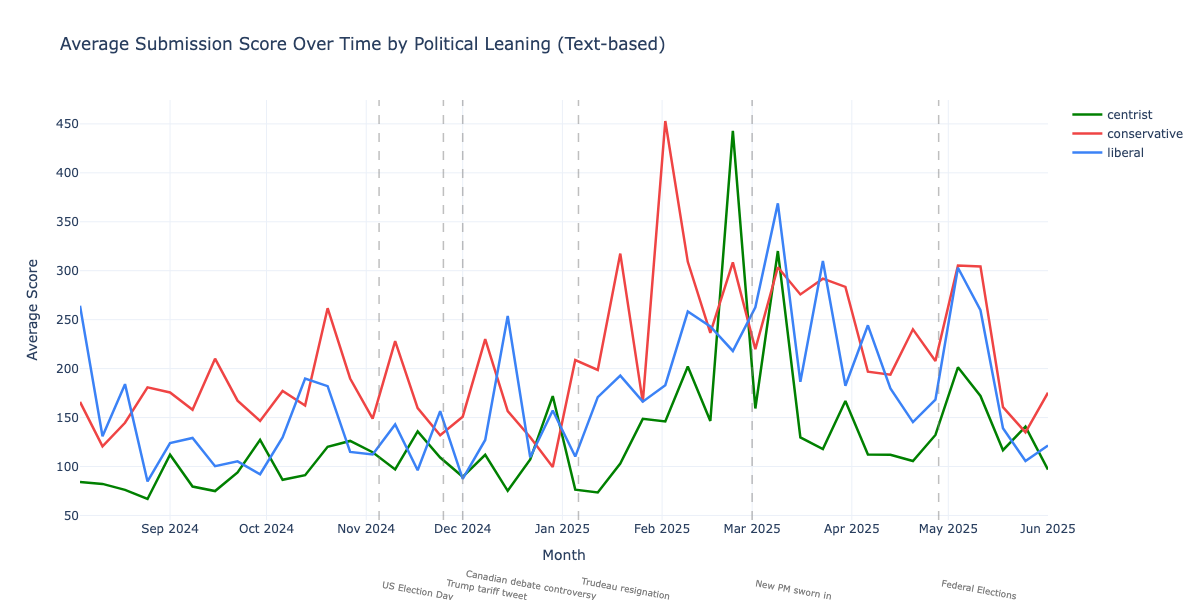

In [146]:
score_trends = (
    election_submissions.groupby([pd.Grouper(key='created_utc', freq='W'), 'political_category'])['score']
    .mean()
    .unstack(fill_value=0)
)

colors = {
    'liberal': '#3B82F6',
    'conservative': '#EF4444',
    'centrist': '#008000'
}

fig = go.Figure()
for col in score_trends.columns:
    fig.add_trace(go.Scatter(
        x=score_trends.index,
        y=score_trends[col],
        mode='lines',
        name=col,
        line=dict(color=colors.get(col, '#000000'), width=2.5)
    ))

add_event_markers(fig, events)

fig.update_layout(
    title='Average Submission Score Over Time by Political Leaning (Text-based)',
    xaxis_title='Month',
    yaxis_title='Average Score',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200
)
fig.show()

In [147]:
daily_scores_conservative = (
    election_submissions[election_submissions['political_category'] == 'conservative']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['score']
    .mean()
    .dropna()
)

daily_scores_liberal = (
    election_submissions[election_submissions['political_category'] == 'liberal']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['score']
    .mean()
    .dropna()
)

common_days = daily_scores_conservative.index.intersection(daily_scores_liberal.index)
conservative_daily = daily_scores_conservative.loc[common_days]
liberal_daily = daily_scores_liberal.loc[common_days]

t_stat_scores, p_value_scores = scipy_stats.ttest_ind(conservative_daily, liberal_daily)

print("=" * 60)
print("T-TEST: Average Submission Score Over Time (Conservative vs Liberal)")
print("=" * 60)
print(f"Conservative daily avg: Mean = {conservative_daily.mean():.2f}, SD = {conservative_daily.std():.2f}, N = {len(conservative_daily)} days")
print(f"Liberal daily avg:      Mean = {liberal_daily.mean():.2f}, SD = {liberal_daily.std():.2f}, N = {len(liberal_daily)} days")
print(f"\nMean difference: {conservative_daily.mean() - liberal_daily.mean():.2f}")
print(f"t-statistic: {t_stat_scores:.4f}")
print(f"p-value: {p_value_scores:.4e}")
print(f"\nResult: {'Statistically significant difference' if p_value_scores < 0.05 else 'No significant difference'} at α = 0.05")
print("=" * 60)

T-TEST: Average Submission Score Over Time (Conservative vs Liberal)
Conservative daily avg: Mean = 204.79, SD = 116.68, N = 304 days
Liberal daily avg:      Mean = 165.22, SD = 124.20, N = 304 days

Mean difference: 39.57
t-statistic: 4.0489
p-value: 5.8135e-05

Result: Statistically significant difference at α = 0.05


## Mean Amount of Comments per Submission Over Time by Political Wing

## Which political wing's submissions received the most reactions?

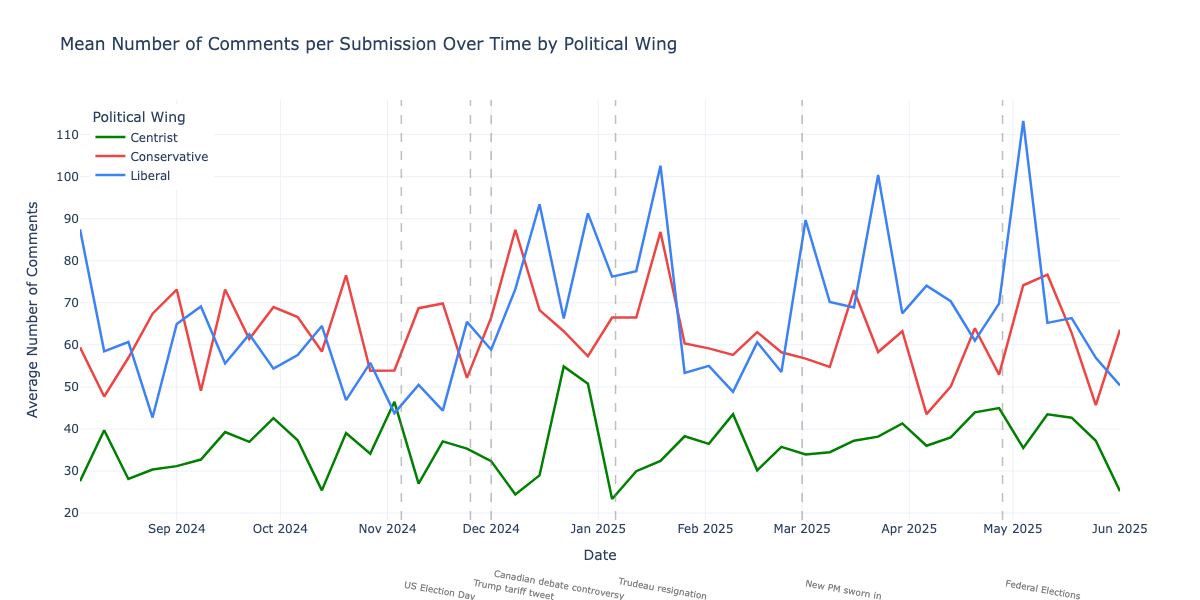

Average comments per submission by political category:
  Centrist: 36.70 comments/submission
  Conservative: 61.98 comments/submission
  Liberal: 69.55 comments/submission


In [148]:
comment_trends = (
    election_submissions.groupby([pd.Grouper(key='created_utc', freq='W'), 'political_category'])['num_comments']
    .mean()
    .unstack(fill_value=0)
)

fig = go.Figure()

colors = {
    'liberal': '#3B82F6',
    'conservative': '#EF4444',
    'centrist': '#008000'
}

for col in comment_trends.columns:
    fig.add_trace(go.Scatter(
        x=comment_trends.index,
        y=comment_trends[col],
        mode='lines',
        name=col.capitalize(),
        line=dict(color=colors.get(col, '#000000'), width=2.5)
    ))

add_event_markers(fig, events)

fig.update_layout(
    title='Mean Number of Comments per Submission Over Time by Political Wing',
    xaxis_title='Date',
    yaxis_title='Average Number of Comments',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        title='Political Wing',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
fig.show()

print("Average comments per submission by political category:")
for category in comment_trends.columns:
    avg_comments = election_submissions[election_submissions['political_category'] == category]['num_comments'].mean()
    print(f"  {category.capitalize()}: {avg_comments:.2f} comments/submission")

In [149]:
daily_comments_conservative = (
    election_submissions[election_submissions['political_category'] == 'conservative']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['num_comments']
    .mean()
    .dropna()
)

daily_comments_liberal = (
    election_submissions[election_submissions['political_category'] == 'liberal']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['num_comments']
    .mean()
    .dropna()
)

common_days_comments = daily_comments_conservative.index.intersection(daily_comments_liberal.index)
conservative_daily_comments = daily_comments_conservative.loc[common_days_comments]
liberal_daily_comments = daily_comments_liberal.loc[common_days_comments]

t_stat_comments, p_value_comments = scipy_stats.ttest_ind(conservative_daily_comments, liberal_daily_comments)

print("=" * 60)
print("T-TEST: Average Comments per Submission Over Time (Conservative vs Liberal)")
print("=" * 60)
print(f"Conservative daily avg: Mean = {conservative_daily_comments.mean():.2f}, SD = {conservative_daily_comments.std():.2f}, N = {len(conservative_daily_comments)} days")
print(f"Liberal daily avg:      Mean = {liberal_daily_comments.mean():.2f}, SD = {liberal_daily_comments.std():.2f}, N = {len(liberal_daily_comments)} days")
print(f"\nMean difference: {conservative_daily_comments.mean() - liberal_daily_comments.mean():.2f}")
print(f"t-statistic: {t_stat_comments:.4f}")
print(f"p-value: {p_value_comments:.4e}")
print(f"\nResult: {'Statistically significant difference' if p_value_comments < 0.05 else 'No significant difference'} at α = 0.05")
print("=" * 60)

T-TEST: Average Comments per Submission Over Time (Conservative vs Liberal)
Conservative daily avg: Mean = 62.15, SD = 21.68, N = 304 days
Liberal daily avg:      Mean = 64.44, SD = 32.35, N = 304 days

Mean difference: -2.28
t-statistic: -1.0220
p-value: 3.0720e-01

Result: No significant difference at α = 0.05


The t-test shows that liberals, on average, wrote more comments on their applications

## Sentiment Score Trends by Political Wing Over Time

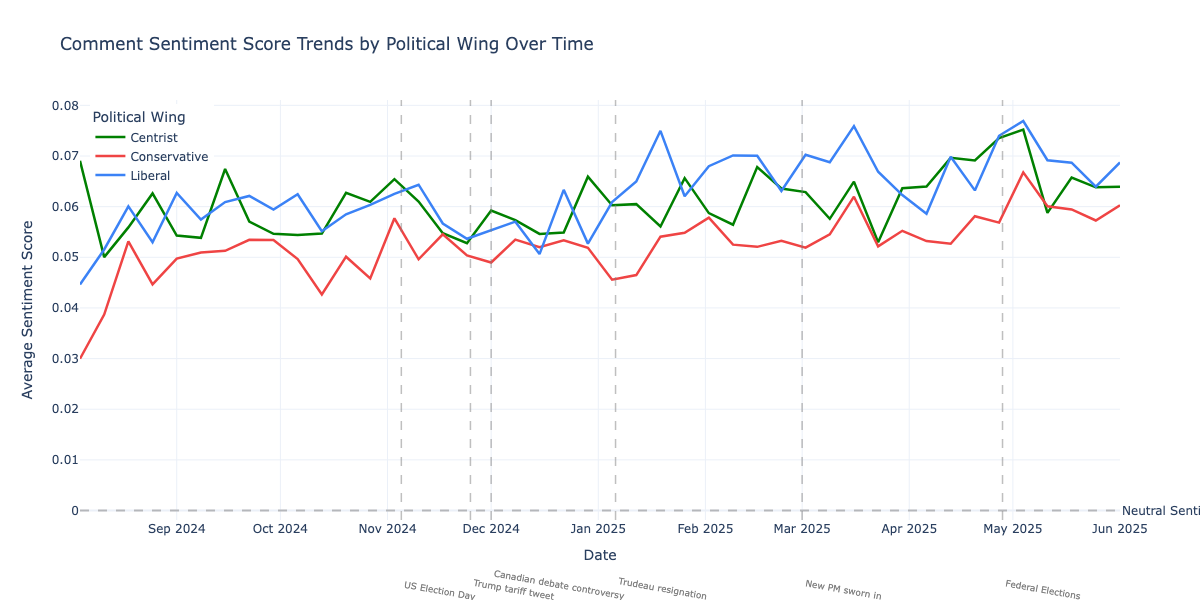

Average comment sentiment score by political category:
  Centrist: 0.0622 (Positive)
  Conservative: 0.0541 (Positive)
  Liberal: 0.0656 (Positive)

Overall comment sentiment statistics:
  Most positive: 0.0769
  Most negative: 0.0300
  Overall average: 0.0591

T-TEST: Average Comment Sentiment Score Over Time (Conservative vs Liberal)
Conservative daily avg: Mean = 0.0527, SD = 0.0089, N = 304 days
Liberal daily avg:      Mean = 0.0628, SD = 0.0111, N = 304 days

Mean difference: -0.0101
t-statistic: -12.3191
p-value: 2.8043e-31

Result: Statistically significant difference at α = 0.05


In [150]:
election_comments['link_id_clean'] = election_comments['link_id'].str.replace("t3_", "", regex=False)

election_comments_with_category = election_comments.merge(
    election_submissions[['id', 'political_category']],
    left_on='link_id_clean',
    right_on='id',
    how='left',
    suffixes=('', '_submission')
)

election_comments_with_category['created_utc'] = pd.to_datetime(
    election_comments_with_category['created_utc'], 
    unit='s', 
    errors='coerce'
)

sentiment_trends_comments = (
    election_comments_with_category.groupby([
        pd.Grouper(key='created_utc', freq='W'), 
        'political_category'
    ])['sentiment_score']
    .mean()
    .unstack(fill_value=0)
)

fig = go.Figure()

colors = {
    'liberal': '#3B82F6',
    'conservative': '#EF4444',
    'centrist': '#008000'
}

for col in sentiment_trends_comments.columns:
    if pd.notna(col):
        fig.add_trace(go.Scatter(
            x=sentiment_trends_comments.index,
            y=sentiment_trends_comments[col],
            mode='lines',
            name=col.capitalize(),
            line=dict(color=colors.get(col, '#000000'), width=2.5)
        ))

fig.add_hline(
    y=0, 
    line_dash="dash", 
    line_color="gray", 
    opacity=0.5,
    annotation_text="Neutral Sentiment",
    annotation_position="right"
)

add_event_markers(fig, events)

fig.update_layout(
    title='Comment Sentiment Score Trends by Political Wing Over Time',
    xaxis_title='Date',
    yaxis_title='Average Sentiment Score',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        title='Political Wing',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
fig.show()

print("Average comment sentiment score by political category:")
for category in sentiment_trends_comments.columns:
    if pd.notna(category):
        avg_sentiment = election_comments_with_category[
            election_comments_with_category['political_category'] == category
        ]['sentiment_score'].mean()
        sentiment_type = "Positive" if avg_sentiment > 0 else "Negative" if avg_sentiment < 0 else "Neutral"
        print(f"  {category.capitalize()}: {avg_sentiment:.4f} ({sentiment_type})")
    
print("\nOverall comment sentiment statistics:")
print(f"  Most positive: {sentiment_trends_comments.max().max():.4f}")
print(f"  Most negative: {sentiment_trends_comments.min().min():.4f}")
print(f"  Overall average: {election_comments_with_category['sentiment_score'].mean():.4f}")

daily_sentiment_conservative_comments = (
    election_comments_with_category[election_comments_with_category['political_category'] == 'conservative']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['sentiment_score']
    .mean()
    .dropna()
)

daily_sentiment_liberal_comments = (
    election_comments_with_category[election_comments_with_category['political_category'] == 'liberal']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['sentiment_score']
    .mean()
    .dropna()
)

common_days_sentiment_comments = daily_sentiment_conservative_comments.index.intersection(daily_sentiment_liberal_comments.index)
conservative_daily_sentiment_comments = daily_sentiment_conservative_comments.loc[common_days_sentiment_comments]
liberal_daily_sentiment_comments = daily_sentiment_liberal_comments.loc[common_days_sentiment_comments]

t_stat_comments, p_value_comments = scipy_stats.ttest_ind(conservative_daily_sentiment_comments, liberal_daily_sentiment_comments)

print("\n" + "=" * 60)
print("T-TEST: Average Comment Sentiment Score Over Time (Conservative vs Liberal)")
print("=" * 60)
print(f"Conservative daily avg: Mean = {conservative_daily_sentiment_comments.mean():.4f}, SD = {conservative_daily_sentiment_comments.std():.4f}, N = {len(conservative_daily_sentiment_comments)} days")
print(f"Liberal daily avg:      Mean = {liberal_daily_sentiment_comments.mean():.4f}, SD = {liberal_daily_sentiment_comments.std():.4f}, N = {len(liberal_daily_sentiment_comments)} days")
print(f"\nMean difference: {conservative_daily_sentiment_comments.mean() - liberal_daily_sentiment_comments.mean():.4f}")
print(f"t-statistic: {t_stat_comments:.4f}")
print(f"p-value: {p_value_comments:.4e}")
print(f"\nResult: {'Statistically significant difference' if p_value_comments < 0.05 else 'No significant difference'} at α = 0.05")
print("=" * 60)

In [151]:
daily_sentiment_conservative = (
    election_submissions[election_submissions['political_category'] == 'conservative']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['sentiment_score']
    .mean()
    .dropna()
)

daily_sentiment_liberal = (
    election_submissions[election_submissions['political_category'] == 'liberal']
    .groupby(pd.Grouper(key='created_utc', freq='D'))['sentiment_score']
    .mean()
    .dropna()
)

common_days_sentiment = daily_sentiment_conservative.index.intersection(daily_sentiment_liberal.index)
conservative_daily_sentiment = daily_sentiment_conservative.loc[common_days_sentiment]
liberal_daily_sentiment = daily_sentiment_liberal.loc[common_days_sentiment]

t_stat, p_value = scipy_stats.ttest_ind(conservative_daily_sentiment, liberal_daily_sentiment)

print("=" * 60)
print("T-TEST: Average Sentiment Score Over Time (Conservative vs Liberal)")
print("=" * 60)
print(f"Conservative daily avg: Mean = {conservative_daily_sentiment.mean():.4f}, SD = {conservative_daily_sentiment.std():.4f}, N = {len(conservative_daily_sentiment)} days")
print(f"Liberal daily avg:      Mean = {liberal_daily_sentiment.mean():.4f}, SD = {liberal_daily_sentiment.std():.4f}, N = {len(liberal_daily_sentiment)} days")
print(f"\nMean difference: {conservative_daily_sentiment.mean() - liberal_daily_sentiment.mean():.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"\nResult: {'Statistically significant difference' if p_value < 0.05 else 'No significant difference'} at α = 0.05")
print("=" * 60)

T-TEST: Average Sentiment Score Over Time (Conservative vs Liberal)
Conservative daily avg: Mean = 0.0175, SD = 0.0437, N = 304 days
Liberal daily avg:      Mean = 0.0437, SD = 0.0505, N = 304 days

Mean difference: -0.0263
t-statistic: -6.8579
p-value: 1.7271e-11

Result: Statistically significant difference at α = 0.05


Liberals also write more positive comments and statements for conservatives

## Subreddit Political Leaning

This number of shares on the subreddit shows that most of our picks don't have strong, distinct views, so it's difficult to understand what views their authors hold. 

Also, the algorithm we used to select election-related data in the beginning is not perfect, but it was the only solution, since it would be difficult to process such a large amount of data using transformer models (it would take a lot of resources in time and money).

The top-2 is certainly conservative, but not for all subreddits at once

## Do subreddits exist with clear political leanings?

In [152]:
significant_subreddits

Index(['AmericaBad', 'AskACanadian', 'Calgary', 'CanadaPolitics',
       'GreenPartyOfCanada', 'Manitoba', 'NovaScotia', 'Quebec', 'QuebecLibre',
       'alberta', 'britishcolumbia', 'canada', 'montreal', 'ndp',
       'newfoundland', 'onguardforthee', 'ontario', 'ottawa', 'saskatchewan',
       'toronto', 'vancouver'],
      dtype='object', name='subreddit')

In [153]:
subreddit_politics = (
    election_submissions
    .groupby(['subreddit', 'political_category'])
    .size()
    .unstack(fill_value=0)
)

subreddit_politics_pct = subreddit_politics.div(subreddit_politics.sum(axis=1), axis=0) * 100

total_submissions_per_subreddit = election_submissions.groupby('subreddit').size()
significant_subreddits = total_submissions_per_subreddit[total_submissions_per_subreddit >= 100].index

subreddit_politics_pct_filtered = subreddit_politics_pct.loc[significant_subreddits]
subreddit_politics_filtered = subreddit_politics.loc[significant_subreddits]

subreddit_politics_pct_sorted = subreddit_politics_pct_filtered.sort_values('liberal', ascending=False)

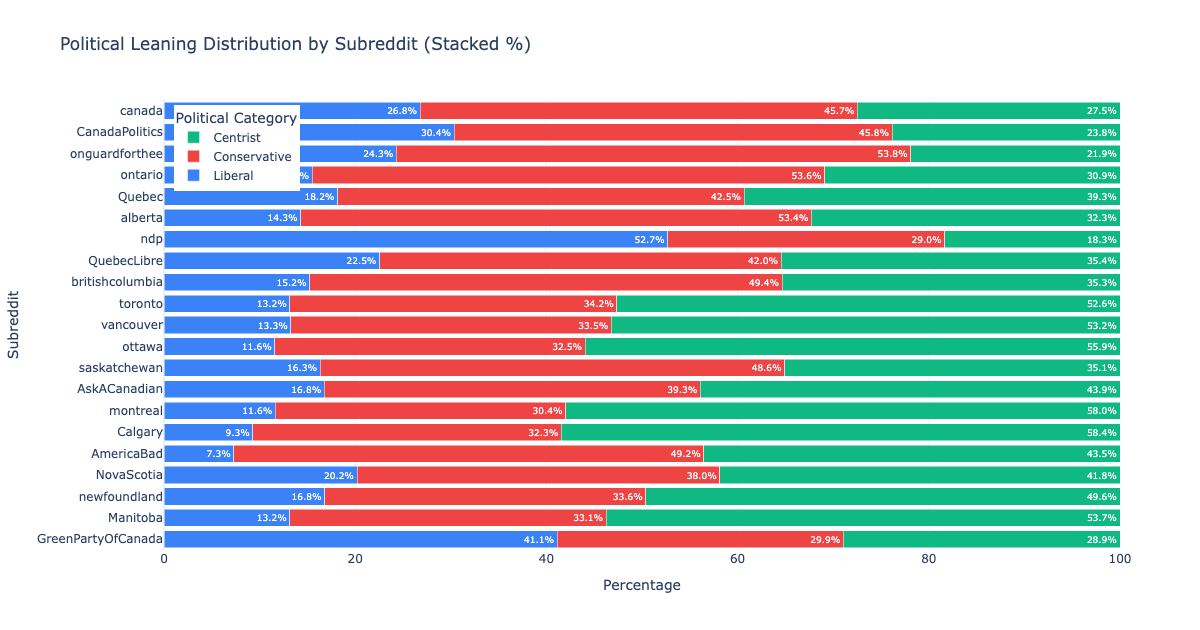

In [154]:
fig = go.Figure()

colors = {
    'liberal': '#3B82F6',
    'conservative': '#EF4444',
    'centrist': '#10B981'
}

sorted_subreddits = subreddit_politics_filtered.sum(axis=1).sort_values(ascending=True).index

for category in ['liberal', 'conservative', 'centrist']:
    if category in subreddit_politics_pct_filtered.columns:
        values = subreddit_politics_pct_filtered.loc[sorted_subreddits, category]
        fig.add_trace(go.Bar(
            name=category.capitalize(),
            y=sorted_subreddits,
            x=values,
            orientation='h',
            marker_color=colors.get(category, '#000000'),
            text=[f"{v:.1f}%" for v in values],
            textposition='inside',
            textfont=dict(size=9, color='white'),
            hovertemplate='<b>%{y}</b><br>' +
                         f'{category.capitalize()}: %{{x:.1f}}%<br>' +
                         '<extra></extra>'
        ))

fig.update_layout(
    title='Political Leaning Distribution by Subreddit (Stacked %)',
    xaxis_title='Percentage',
    yaxis_title='Subreddit',
    barmode='stack',
    template='plotly_white',
    height=max(600, len(sorted_subreddits) * 30),
    width=1200,
    showlegend=True,
    legend=dict(
        title='Political Category',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    xaxis=dict(range=[0, 100])
)
fig.show()

# Entity Analysis

## Entity Mentions in Election Content

Here, we used output from Named Entity Recognition models to find the most frequently occurring people in our subscriptions. Sometimes the model can recognize the same person as two different individuals (e.g. Trudeau and Justin Trudeau), so we decided to keep only the last part of the name (usually the last name). Pronouns can also occur in tops

## Who appeared most frequently in election-related posts?

Most Popular People:
Trudeau: 4135
Poilievre: 2217
Ford: 1828
Carney: 1718
Trump: 1460
Smith: 1189
Singh: 398
MLA: 250
Harper: 215
Pierre: 204


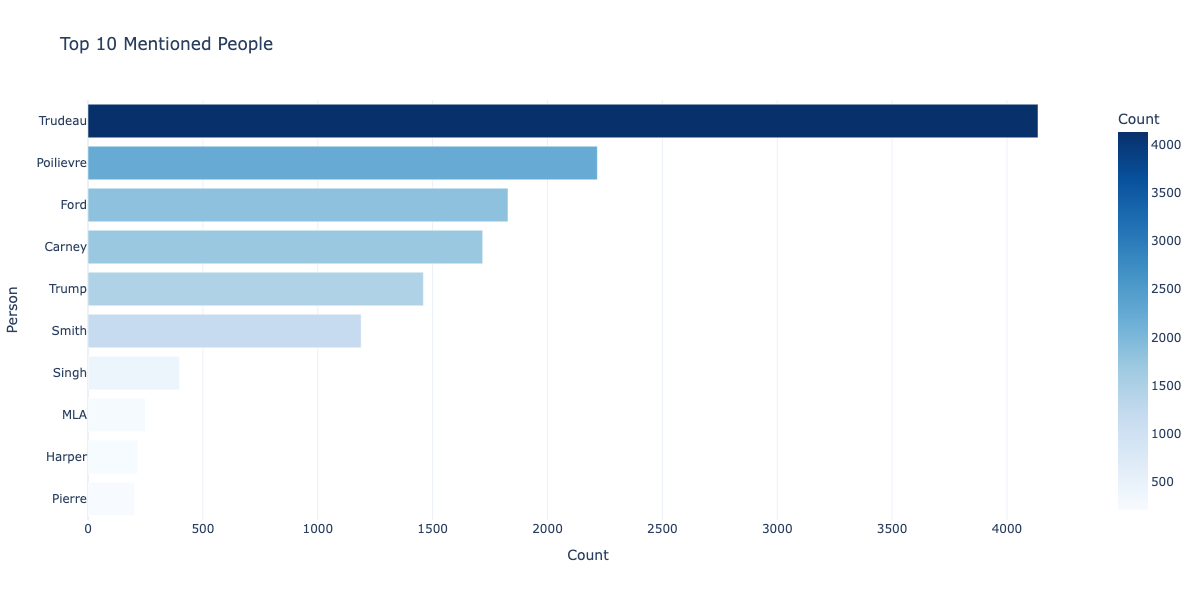

In [155]:
all_people = election_submissions['people'].dropna().str.split(', ')
all_people_flat = [person.split()[-1] for sublist in all_people for person in sublist if person]

people_counter = Counter(all_people_flat)

most_common_people = people_counter.most_common(10)

print("Most Popular People:")
for person, count in most_common_people:
    print(f"{person}: {count}")

top_people_df = pd.DataFrame(most_common_people, columns=['Person', 'Count'])

fig = px.bar(
    top_people_df,
    x='Count',
    y='Person',
    orientation='h',
    title='Top 10 Mentioned People',
    color='Count',
    color_continuous_scale='Blues'
)
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_white',
    height=600,
    width=1200,
)
fig.show()

This visualization will examine Justin Trudeau, Trump, Mark Carney, and Pierre Poilievre as the primary figures of interest.

In [156]:
political_figures = {
    'Trump': r'\btrump\b',
    'Trudeau': r'\btrudeau\b',
    'Poilievre': r'\bpoilievre\b',
    'Carney': r'\bcarney\b'
}

for figure, pattern in political_figures.items():
    election_submissions[f'mentions_{figure.lower()}'] = (
        election_submissions['title'].fillna('').str.contains(pattern, case=False, regex=True) |
        election_submissions['selftext'].fillna('').str.contains(pattern, case=False, regex=True)
    )

In [157]:
weekly_mentions = {}

for figure in political_figures.keys():
    weekly_mentions[figure] = (
        election_submissions[election_submissions[f'mentions_{figure.lower()}']]
        .groupby(pd.Grouper(key='created_utc', freq='W'))
        .size()
    )

mentions_df = pd.DataFrame(weekly_mentions).fillna(0)

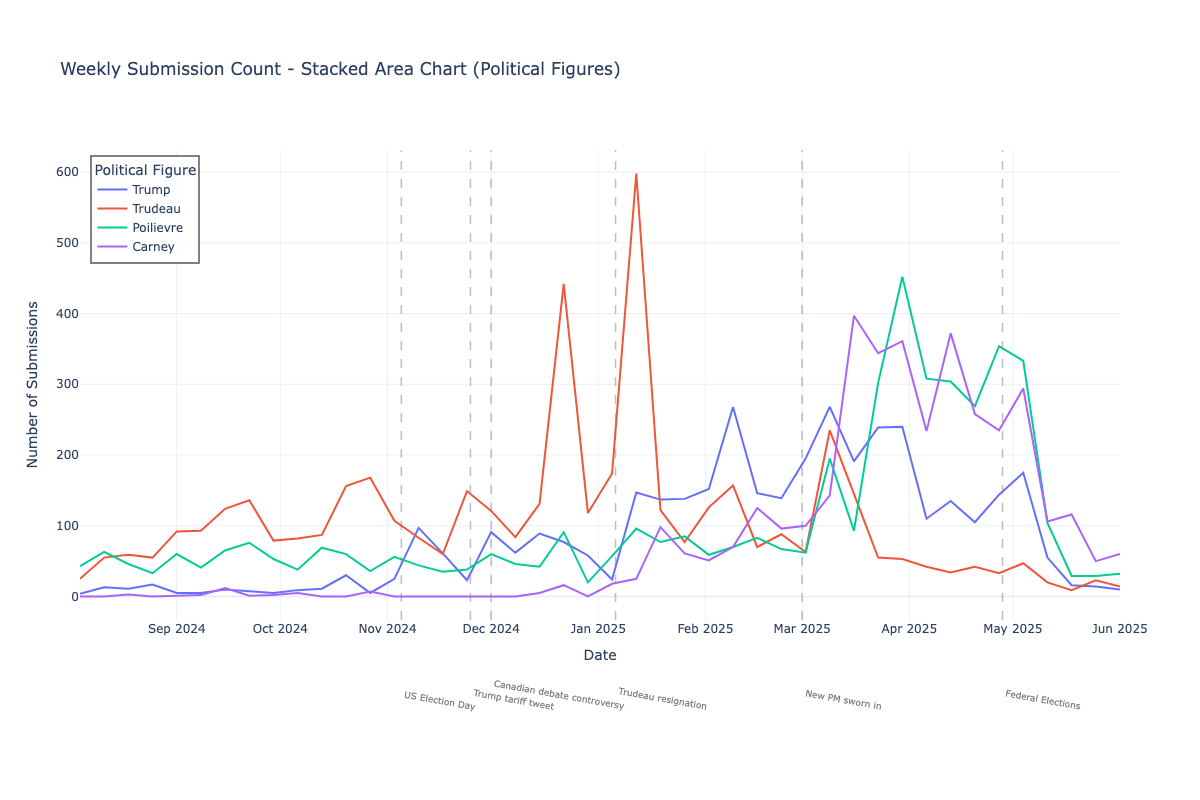

In [158]:
fig_area = go.Figure()

for figure in political_figures.keys():
    fig_area.add_trace(go.Scatter(
        x=mentions_df.index,
        y=mentions_df[figure],
        mode='lines',
        name=figure,
        line=dict(width=2)
    ))

add_event_markers(fig_area, events)

fig_area.update_layout(
    title='Weekly Submission Count - Stacked Area Chart (Political Figures)',
    xaxis_title='Date',
    yaxis_title='Number of Submissions',
    template='plotly_white',
    hovermode='x unified',
    height=800,
    width=1200,
    margin=dict(t=150, b=180, l=80, r=80),
    legend=dict(
        title='Political Figure',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=2
    )
)

fig_area.show()

If we look at `Average Submission Score Over Time by Political Leaning (Text-based)` than we can understand that Donald Trump is so popular in submissions cause r/canada wrote a lot of news with his mentions after his ininauguration

## Where did key political figures appear most frequently?

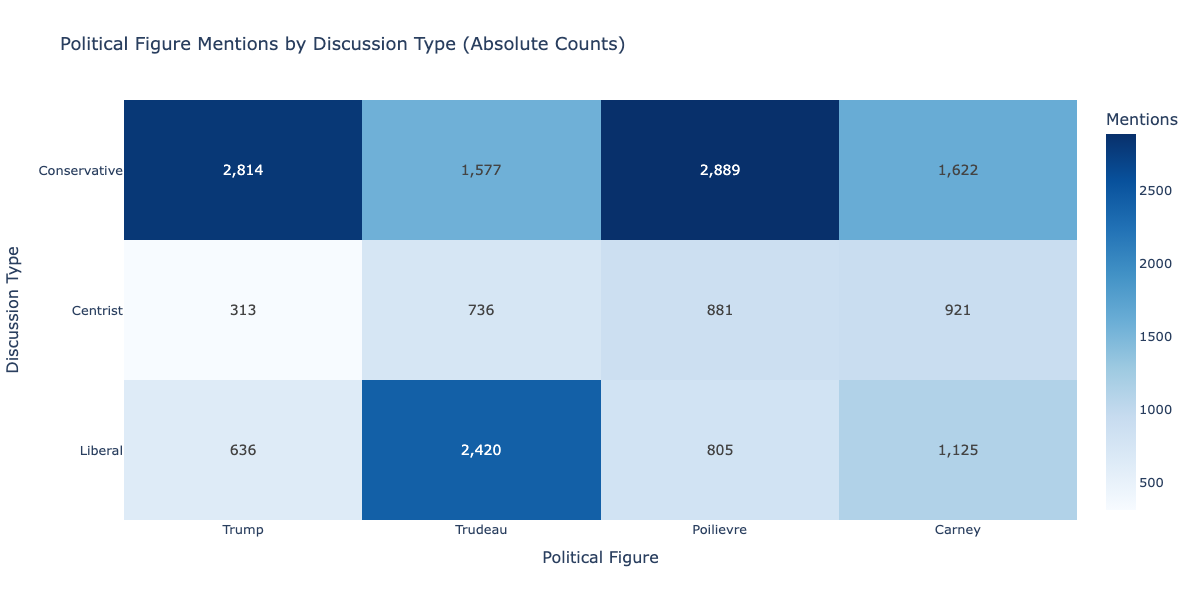

In [159]:
figure_political_context = {}

for figure in political_figures.keys():
    counts_by_category = (
        election_submissions[election_submissions[f'mentions_{figure.lower()}']]
        .groupby('political_category')
        .size()
    )
    figure_political_context[figure] = counts_by_category

context_df = pd.DataFrame(figure_political_context).fillna(0)
context_df = context_df.reindex(['liberal', 'centrist', 'conservative'], fill_value=0)

context_pct = context_df.div(context_df.sum(axis=1), axis=0) * 100

fig_heatmap1 = go.Figure(data=go.Heatmap(
    z=context_df.values,
    x=context_df.columns,
    y=['Liberal', 'Centrist', 'Conservative'],
    colorscale='Blues',
    text=context_df.values.astype(int),
    texttemplate='%{text:,}',
    textfont={"size": 14},
    colorbar=dict(title="Mentions"),
    hovertemplate='<b>%{y} discussions</b><br>' +
                 'Figure: %{x}<br>' +
                 'Mentions: %{z:,}<br>' +
                 '<extra></extra>'
))

fig_heatmap1.update_layout(
    title='Political Figure Mentions by Discussion Type (Absolute Counts)',
    xaxis_title='Political Figure',
    yaxis_title='Discussion Type',
    template='plotly_white',
    height=600,
    width=1200,
    font=dict(size=13),
    xaxis=dict(side='bottom'),
)

fig_heatmap1.show()

In [160]:
election_submissions[election_submissions[f'mentions_{figure.lower()}']].groupby('political_category').size()

political_category
centrist         921
conservative    1622
liberal         1125
dtype: int64

The data reveals distinct partisan attention patterns: Conservative forums concentrate heavily on Trump and Poilievre, while Liberal discussions focus more on Trudeau, reflecting the political alignment of each discussion type.

In [166]:
def plot_sentiment_by_figure(figure_name, freq='W'):
    figure_lower = figure_name.lower()
   
    figure_submissions = election_submissions[election_submissions[f'mentions_{figure_lower}']].copy()
    
    if len(figure_submissions) == 0:
        print(f"No submissions found mentioning {figure_name}")
        return
    

    grouped = figure_submissions.groupby([pd.Grouper(key='created_utc', freq=freq), 'political_category'])
    
    sentiment_sum = grouped['sentiment_score'].sum().unstack(fill_value=0)
    submission_counts = grouped.size().unstack(fill_value=0)
    
    sentiment_trends = sentiment_sum.div(submission_counts).fillna(0)
    
    fig_line = go.Figure()
    
    colors = {
        'liberal': '#3B82F6',
        'conservative': '#EF4444',
        'centrist': '#10B981'
    }
    
    for category in ['liberal', 'centrist', 'conservative']:
        if category in sentiment_trends.columns:
            fig_line.add_trace(go.Scatter(
                x=sentiment_trends.index,
                y=sentiment_trends[category],
                mode='lines+markers',
                name=category.capitalize(),
                line=dict(color=colors[category], width=3),
                marker=dict(size=5),
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Date: %{x|%Y-%m-%d}<br>' +
                             'Sentiment: %{y:.4f}<br>' +
                             '<extra></extra>'
            ))
    
    fig_line.add_hline(
        y=0, 
        line_dash="dash", 
        line_color="gray", 
        opacity=0.5,
        annotation_text="Neutral",
        annotation_position="right"
    )
    
    add_event_markers(fig_line, events)
    
    freq_label = {'W': 'Weekly', 'M': 'Monthly', 'D': 'Daily'}
    fig_line.update_layout(
        title=f'{freq_label.get(freq, "Time-series")} Sentiment Toward {figure_name} by Discussion Type (Weighted Average)',
        xaxis_title='Date',
        yaxis_title='Mean Sentiment Score',
        template='plotly_white',
        hovermode='x unified',
        height=600,
        width=1200,
        legend=dict(
            title='Discussion Type',
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='gray',
            borderwidth=1
        )
    )
    
    fig_line.show()
    total_sentiment = figure_submissions.groupby('political_category')['sentiment_score'].sum()
    total_submissions = figure_submissions.groupby('political_category').size()
    
    avg_sentiment = (total_sentiment / total_submissions).reindex(['liberal', 'centrist', 'conservative'])
    
    fig_bar = go.Figure()
    
    bar_colors = [colors[cat] for cat in ['liberal', 'centrist', 'conservative']]
    
    fig_bar.add_trace(go.Bar(
        x=['Liberal', 'Centrist', 'Conservative'],
        y=avg_sentiment.values,
        marker=dict(
            color=bar_colors,
            line=dict(color='white', width=1)
        ),
        text=[f"{val:.4f}" for val in avg_sentiment.values],
        textposition='outside',
        textfont=dict(size=14, color='black'),
        hovertemplate='<b>%{x}</b><br>' +
                     'Mean Sentiment: %{y:.4f}<br>' +
                     '<extra></extra>'
    ))
    
    fig_bar.add_hline(
        y=0, 
        line_dash="dash", 
        line_color="gray", 
        opacity=0.5,
        annotation_text="Neutral",
        annotation_position="right"
    )
    
    fig_bar.update_layout(
        title=f'Overall Mean Sentiment Toward {figure_name} by Discussion Type',
        xaxis_title='Discussion Type',
        yaxis_title='Mean Sentiment Score',
        template='plotly_white',
        height=500,
        showlegend=False,
        font=dict(size=13)
    )
    
    fig_bar.show()

## What was the sentiment toward key political figures across different political wings?

Justin Trudeau is the only person in this study who has a negative mood on average

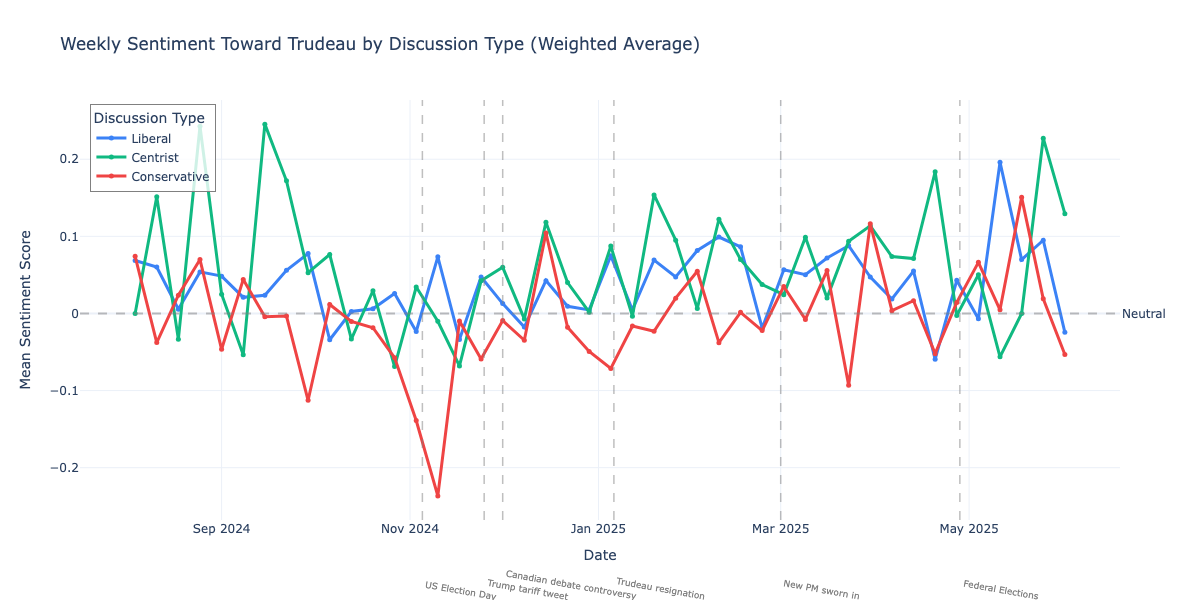

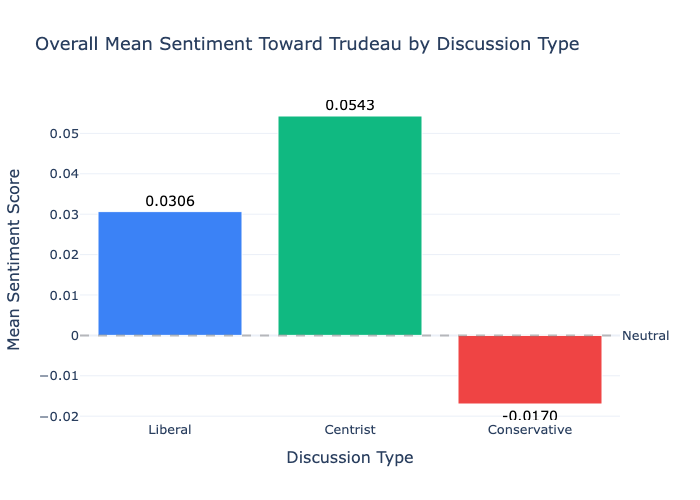

In [167]:
plot_sentiment_by_figure('Trudeau', freq='W')

Donald Trump has positive sentiment on average across every group, surprisingly for conservatives he is the least

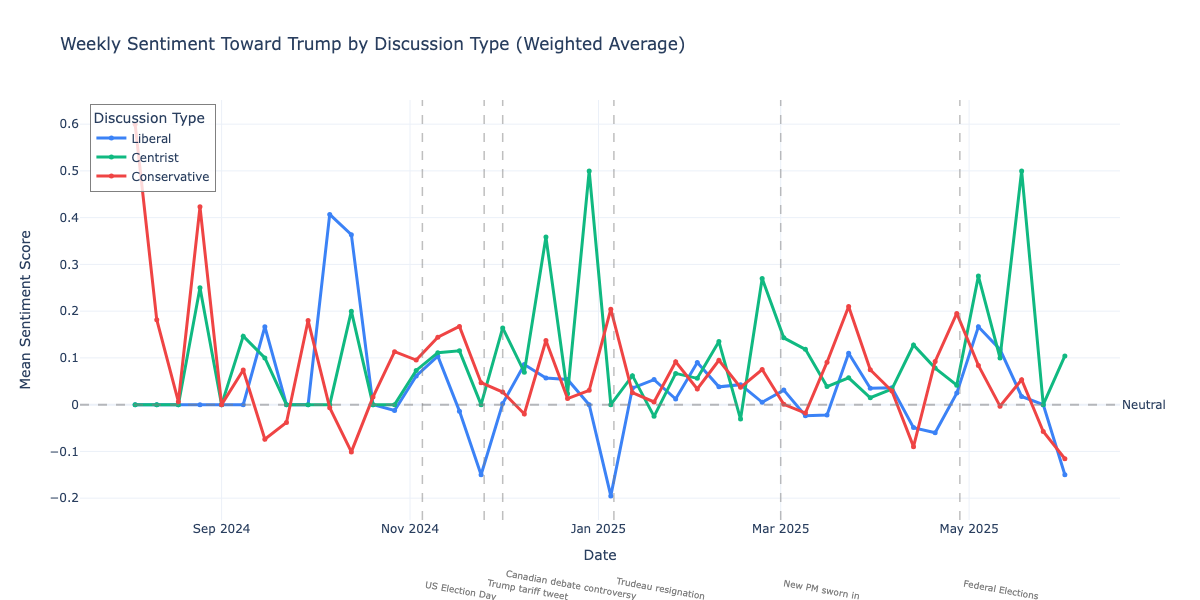

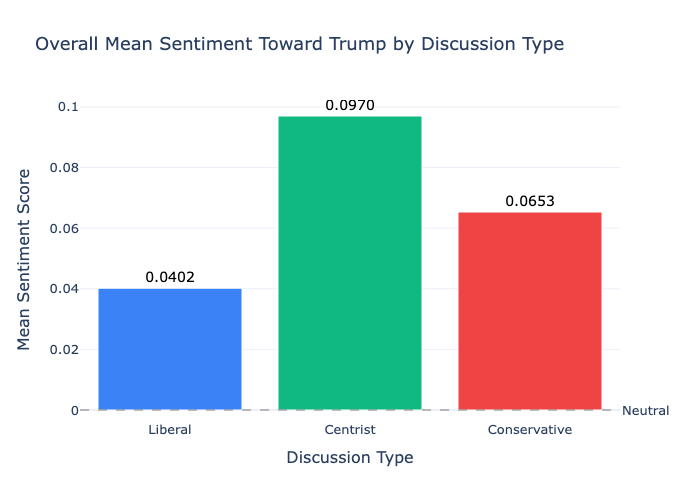

In [168]:
plot_sentiment_by_figure('Trump', freq='W')

Although Carney appeared in the subs only towards the end of the period, he has a positive average sentiment both among his like-minded people and among conservatives, who reflect a different wing.

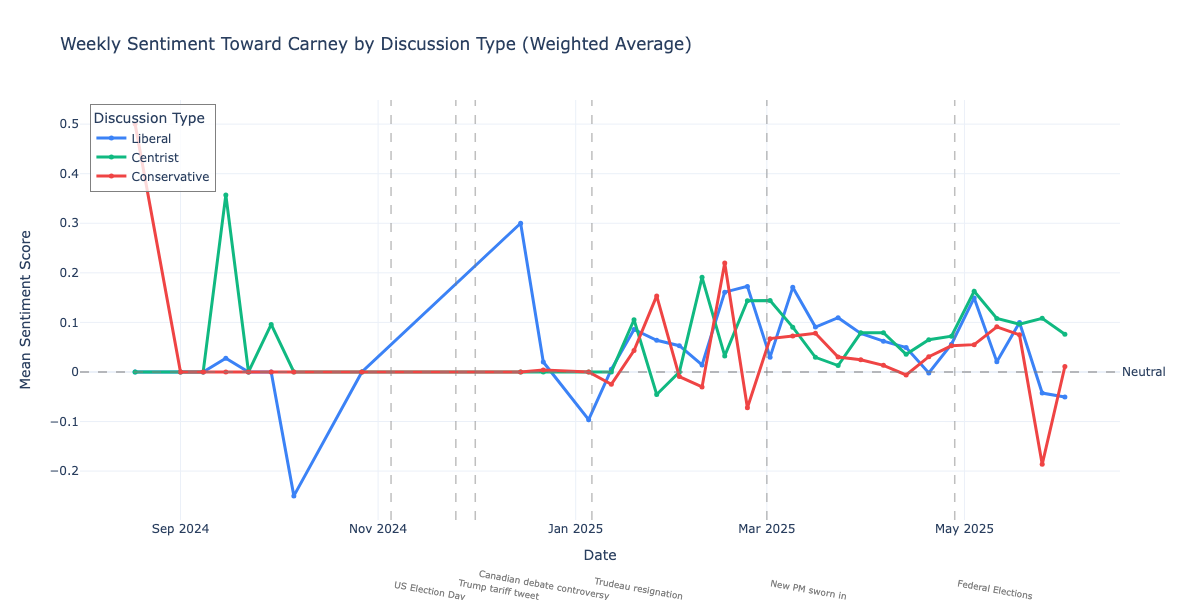

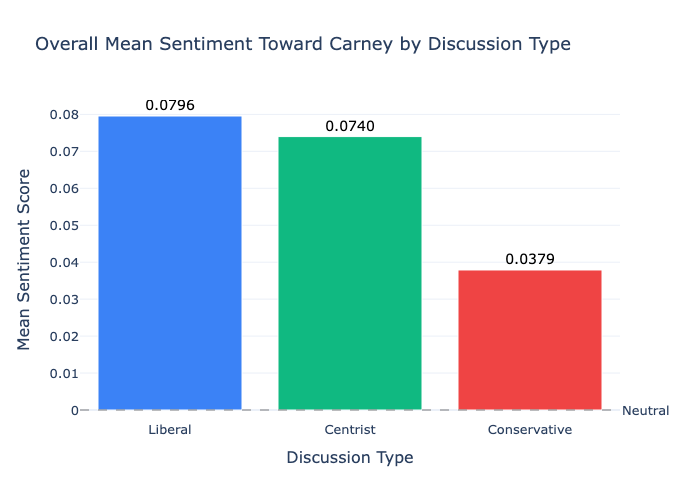

In [169]:
plot_sentiment_by_figure('Carney', freq='W')

The opposite situation is with Poilievre, because his wing has less sentiment, this is possible because in this data, conservatives generally have lower positive scores.

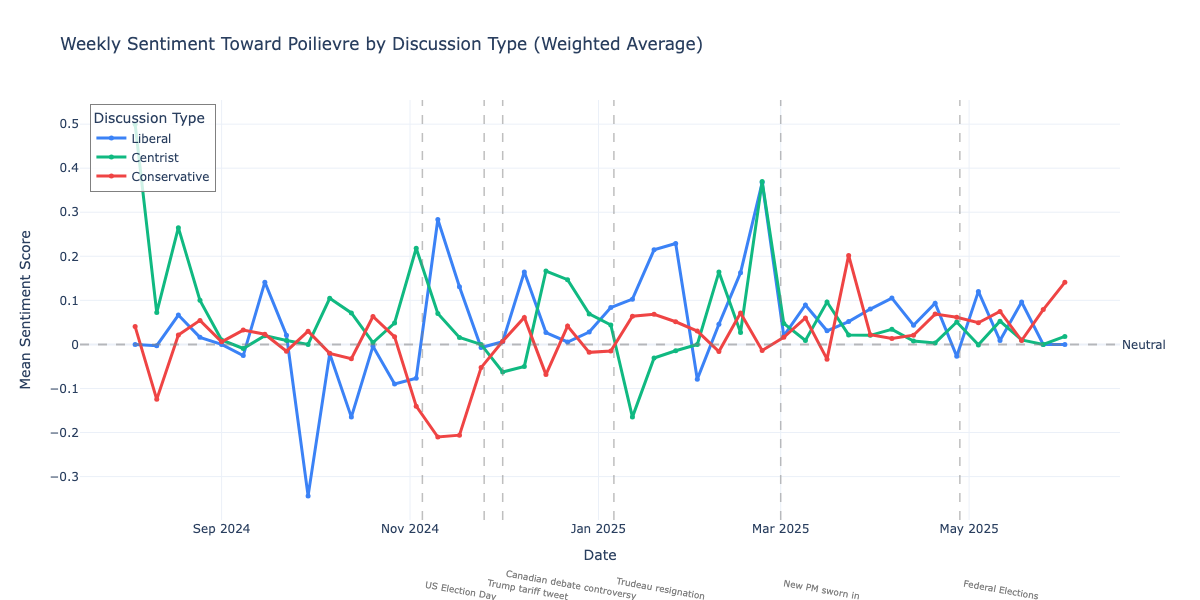

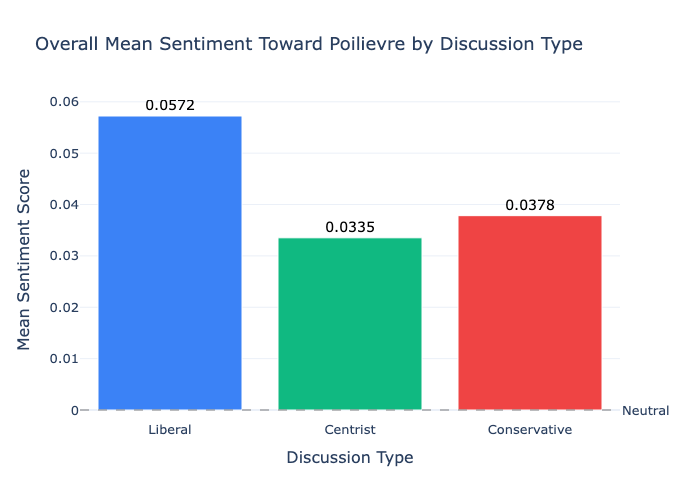

In [170]:
plot_sentiment_by_figure('Poilievre', freq='W')

## Causal Inference

### Event Impact Analysis

To test this hypothesis, we divided the timeline into periods before and after key events. We then applied t-tests to compare sentiment across these periods. This statistical approach allowed us to determine whether sentiment had significantly changed following each event, validating our initial observations with quantitative evidence. We applied this type of analysis separately for applications and comments. Check out the list of events you can below:

* US Election Day
* Trump tariff tweet
* Canadian debate controversy
* Trudeau resignation
* New PM sworn in


## What was the impact of major political events (Trump tariff tweet, Trudeau resignation)?

In [171]:
def analyze_event_impact(df, event_date, group_column='subreddit',
                         sentiment_column='sentiment', days_before=30, days_after=30):
    event_dt = pd.to_datetime(event_date)

    before = df[(df.index >= event_dt - pd.Timedelta(days=days_before)) &
                (df.index < event_dt)]
    after = df[(df.index >= event_dt) &
               (df.index <= event_dt + pd.Timedelta(days=days_after))]

    results = {}

    for group_name in df[group_column].unique():
        before_group = before[before[group_column] == group_name][sentiment_column]
        after_group = after[after[group_column] == group_name][sentiment_column]

        if len(before_group) == 0 or len(after_group) == 0:
            results[group_name] = {
                'error': f'Insufficient data (Before: {len(before_group)}, After: {len(after_group)})'
            }
            continue

        mean_before = before_group.mean()
        mean_after = after_group.mean()
        std_before = before_group.std()
        std_after = after_group.std()
        n_before = len(before_group)
        n_after = len(after_group)

        t_stat, p_value = scipy_stats.ttest_ind(before_group, after_group, equal_var=False)

        pooled_std = np.sqrt(((n_before - 1) * std_before**2 + (n_after - 1) * std_after**2) /
                            (n_before + n_after - 2))
        cohens_d = (mean_after - mean_before) / pooled_std if pooled_std != 0 else 0

        direction = "increase" if mean_after > mean_before else "decrease" if mean_after < mean_before else "no change"
        effect_size = "large" if abs(cohens_d) >= 0.8 else "medium" if abs(cohens_d) >= 0.5 else "small" if abs(cohens_d) >= 0.2 else "negligible"

        results[group_name] = {
            'mean_before': mean_before,
            'mean_after': mean_after,
            'mean_difference': mean_after - mean_before,
            'std_before': std_before,
            'std_after': std_after,
            'n_before': n_before,
            'n_after': n_after,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'effect_size': effect_size,
            'direction': direction
        }

    return results

In [172]:
election_submissions_filtered = election_submissions[
    election_submissions['political_category'].isin(['conservative', 'liberal'])
].copy()
election_submissions_filtered['date'] = pd.to_datetime(election_submissions_filtered['created_utc']).dt.date

daily_sentiment = (
    election_submissions_filtered
    .groupby(['date', 'political_category'])['sentiment_score']
    .mean()
    .reset_index()
)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
daily_sentiment = daily_sentiment.set_index('date')

key_events = [
    ("2024-11-05", "US Election Day"),
    ("2024-11-25", "Trump tariff tweet"),
    ("2024-12-01", "Canadian debate controversy"),
    ("2025-01-06", "Trudeau resignation"),
    ("2025-03-01", "New PM sworn in")
]

all_results = {}

for event_date, event_name in key_events:
    results = analyze_event_impact(
        df=daily_sentiment,
        event_date=event_date,
        group_column='political_category',
        sentiment_column='sentiment_score',
        days_before=30,
        days_after=30
    )
    all_results[event_name] = results

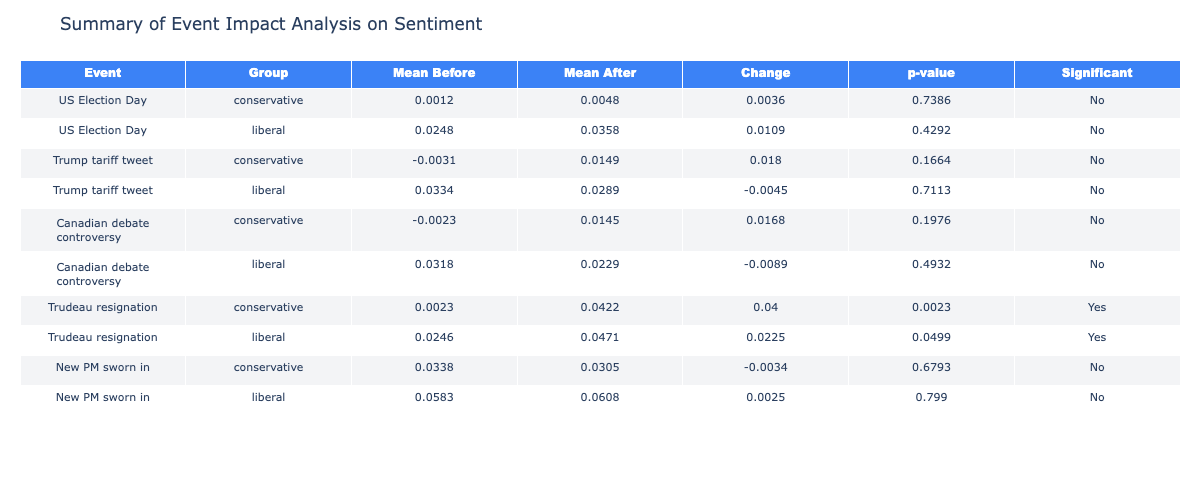

In [173]:
summary_data = []

for event_name, results in all_results.items():
    for group_name in results.keys():
        if 'error' not in results[group_name]:
            result = results[group_name]
            summary_data.append({
                'Event': event_name,
                'Group': group_name,
                'Mean Before': round(result['mean_before'], 4),
                'Mean After': round(result['mean_after'], 4),
                'Change': round(result['mean_difference'], 4),
                'p-value': round(result['p_value'], 4),
                'Significant': 'Yes' if result['significant'] else 'No'
            })

summary_df = pd.DataFrame(summary_data)

fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary_df.columns),
        fill_color='#3B82F6',
        align='center',
        font=dict(color='white', size=12, family='Arial Black')
    ),
    cells=dict(
        values=[summary_df[col] for col in summary_df.columns],
        fill_color=[
            ['#F3F4F6' if i % 2 == 0 else 'white' for i in range(len(summary_df))]
        ],
        align='center',
        font=dict(size=11),
        height=30
    )
)])

fig.update_layout(
    title='Summary of Event Impact Analysis on Sentiment',
    height=max(400, len(summary_df) * 40 + 100),
    width=1200,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

At the submission level, we see that the Liberals' sentiment score increased after Trudeau's resignation, we can assume that the Liberals did not so much want to change their political wing as they did not like Trudeau himself as a minister.

In [174]:
def analyze_event_impact_comments(election_comments, election_submissions, event_date, 
                                   group_column='political_category',
                                   sentiment_column='sentiment_score', 
                                   days_before=30, days_after=30):
    election_comments['link_id_clean'] = election_comments['link_id'].str.replace("t3_", "", regex=False)
    
    comments_with_category = election_comments.merge(
        election_submissions[['id', 'political_category']],
        left_on='link_id_clean',
        right_on='id',
        how='left',
        suffixes=('', '_submission')
    )

    comments_with_category['created_utc'] = pd.to_datetime(
        comments_with_category['created_utc'], 
        unit='s', 
        errors='coerce'
    )
    comments_with_category = comments_with_category.set_index('created_utc')
    
    event_dt = pd.to_datetime(event_date)

    before = comments_with_category[
        (comments_with_category.index >= event_dt - pd.Timedelta(days=days_before)) &
        (comments_with_category.index < event_dt)
    ]
    after = comments_with_category[
        (comments_with_category.index >= event_dt) &
        (comments_with_category.index <= event_dt + pd.Timedelta(days=days_after))
    ]
    
    results = {}

    for group_name in comments_with_category[group_column].dropna().unique():
        before_group = before[before[group_column] == group_name][sentiment_column]
        after_group = after[after[group_column] == group_name][sentiment_column]
        
        if len(before_group) == 0 or len(after_group) == 0:
            results[group_name] = {
                'error': f'Insufficient data (Before: {len(before_group)}, After: {len(after_group)})'
            }
            continue
        
        mean_before = before_group.mean()
        mean_after = after_group.mean()
        std_before = before_group.std()
        std_after = after_group.std()
        n_before = len(before_group)
        n_after = len(after_group)
        
        t_stat, p_value = scipy_stats.ttest_ind(before_group, after_group, equal_var=False)
        
        pooled_std = np.sqrt(((n_before - 1) * std_before**2 + (n_after - 1) * std_after**2) /
                            (n_before + n_after - 2))
        cohens_d = (mean_after - mean_before) / pooled_std if pooled_std != 0 else 0
        
        direction = "increase" if mean_after > mean_before else "decrease" if mean_after < mean_before else "no change"
        effect_size = "large" if abs(cohens_d) >= 0.8 else "medium" if abs(cohens_d) >= 0.5 else "small" if abs(cohens_d) >= 0.2 else "negligible"
        
        results[group_name] = {
            'mean_before': mean_before,
            'mean_after': mean_after,
            'mean_difference': mean_after - mean_before,
            'std_before': std_before,
            'std_after': std_after,
            'n_before': n_before,
            'n_after': n_after,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'effect_size': effect_size,
            'direction': direction
        }
    
    return results


results = analyze_event_impact_comments(
    election_comments, 
    election_submissions,
    event_date="2025-01-06",
    days_before=30,
    days_after=30
)

In [175]:
election_comments['link_id_clean'] = election_comments['link_id'].str.replace("t3_", "", regex=False)

election_comments_with_category = election_comments.merge(
    election_submissions[['id', 'political_category']],
    left_on='link_id_clean',
    right_on='id',
    how='left',
    suffixes=('', '_submission')
)

election_comments_filtered = election_comments_with_category[
    election_comments_with_category['political_category'].isin(['conservative', 'liberal'])
].copy()

election_comments_filtered['created_utc'] = pd.to_datetime(
    election_comments_filtered['created_utc'], 
    unit='s', 
    errors='coerce'
)

key_events = [
    ("2024-11-05", "US Election Day"),
    ("2024-11-25", "Trump tariff tweet"),
    ("2024-12-01", "Canadian debate controversy"),
    ("2025-01-06", "Trudeau resignation"),
    ("2025-03-01", "New PM sworn in")
]

all_results_comments = {}

for event_date, event_name in key_events:
    results = analyze_event_impact_comments(
        election_comments=election_comments,
        election_submissions=election_submissions,
        event_date=event_date,
        group_column='political_category',
        sentiment_column='sentiment_score',
        days_before=30,
        days_after=30
    )
    
    filtered_results = {k: v for k, v in results.items() if k in ['conservative', 'liberal']}
    all_results_comments[event_name] = filtered_results

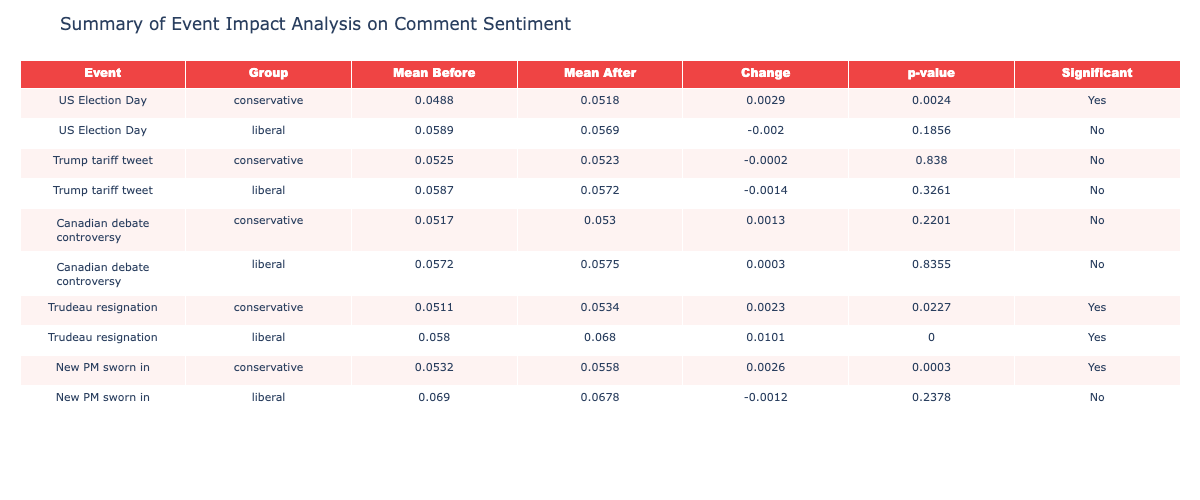

In [176]:
summary_data_comments = []

for event_name, results in all_results_comments.items():
    for group_name in results.keys():
        if 'error' not in results[group_name]:
            result = results[group_name]
            summary_data_comments.append({
                'Event': event_name,
                'Group': group_name,
                'Mean Before': round(result['mean_before'], 4),
                'Mean After': round(result['mean_after'], 4),
                'Change': round(result['mean_difference'], 4),
                'p-value': round(result['p_value'], 4),
                'Significant': 'Yes' if result['significant'] else 'No'
            })

summary_df_comments = pd.DataFrame(summary_data_comments)

fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary_df_comments.columns),
        fill_color='#EF4444',
        align='center',
        font=dict(color='white', size=12, family='Arial Black')
    ),
    cells=dict(
        values=[summary_df_comments[col] for col in summary_df_comments.columns],
        fill_color=[
            ['#FEF3F2' if i % 2 == 0 else 'white' for i in range(len(summary_df_comments))]
        ],
        align='center',
        font=dict(size=11),
        height=30
    )
)])

fig.update_layout(
    title='Summary of Event Impact Analysis on Comment Sentiment',
    height=max(400, len(summary_df_comments) * 40 + 100),
    width=1200,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

The comments reveal more statistically significant sentiment changes and better represent community opinion. The most striking shift occurs around US Election Day—after Donald Trump's selection as the 47th President of the United States, conservative sentiment scores increased significantly. 

The same pattern observed in submissions appears in comments regarding Trudeau's resignation. Both liberals and conservatives responded positively to Mark Carney's entrance into the political arena, showing cross-partisan support for his candidacy.